In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [ ]:
from datasets import load_dataset, Dataset

# Load the dataset from Hugging Face
dataset = load_dataset("BothBosu/agent-scam-conversation")
dataset = dataset.remove_columns("type")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

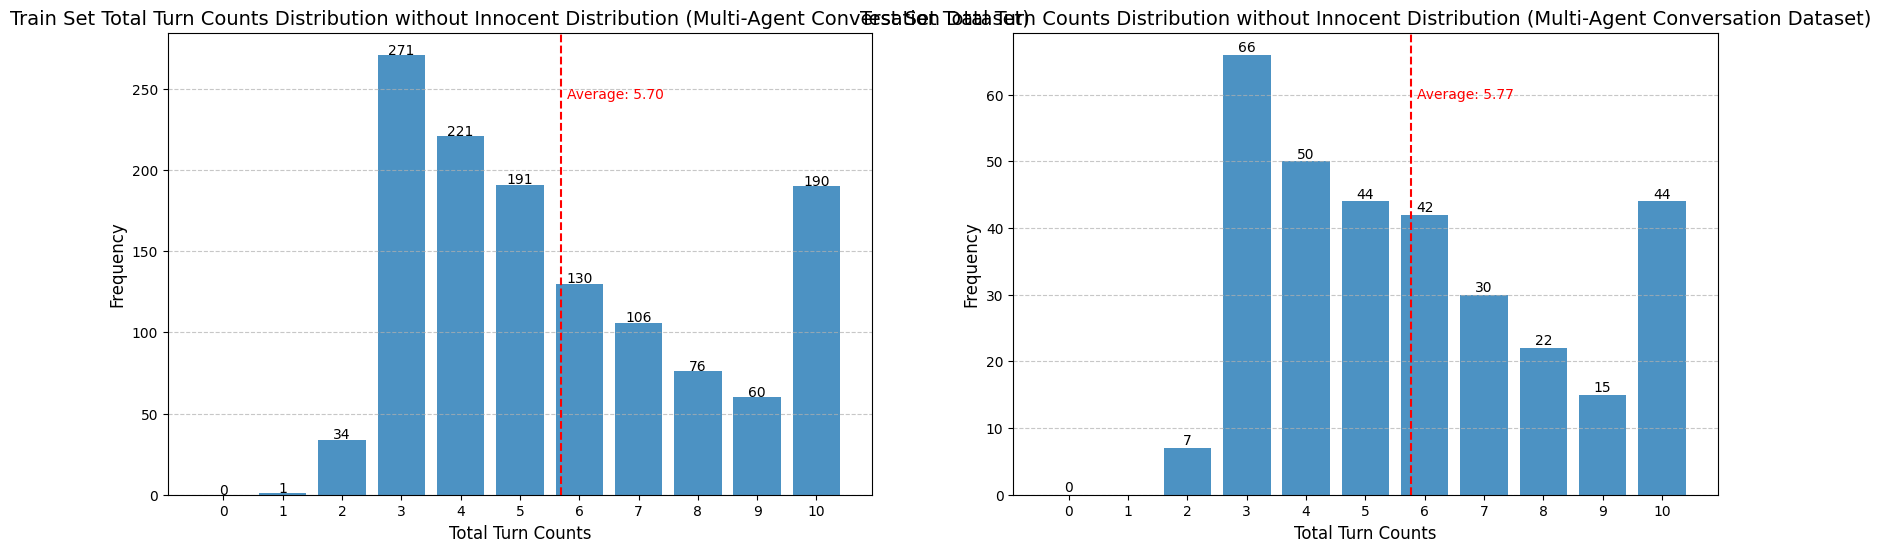

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_dataset = dataset["train"]
test_dataset = dataset["test"]
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Function to filter only the suspect's dialogue and remove the 'suspect:' string
def filter_suspect_dialogue(dialogue):
    parts = dialogue.split(' ')
    suspect_dialogue = []
    is_suspect = False
    for part in parts:
        if part.startswith('Suspect:'):
            is_suspect = True
        elif part.startswith('Innocent:'):
            is_suspect = False
        if is_suspect:
            suspect_dialogue.append(part)
    return ' '.join(suspect_dialogue).strip()

# Apply the function to the DataFrame
train_df['dialogue'] = train_df['dialogue'].apply(filter_suspect_dialogue)
test_df['dialogue'] = test_df['dialogue'].apply(filter_suspect_dialogue)

# Count the occurrences of "suspect:" and "innocent:" in each row
train_df['suspect_turns'] = train_df['dialogue'].str.count('Suspect:')
train_df['innocent_turns'] = train_df['dialogue'].str.count('Innocent:')
test_df['suspect_turns'] = test_df['dialogue'].str.count('Suspect:')
test_df['innocent_turns'] = test_df['dialogue'].str.count('Innocent:')

# Compute the total turns of "suspect:" and "innocent:" in each row
train_df['total_turns'] = train_df['suspect_turns'] + train_df['innocent_turns']
test_df['total_turns'] = test_df['suspect_turns'] + test_df['innocent_turns']

# Function to create the histogram plot
def plot_turn_counts_distribution(df, title, ax):
    # Calculate the frequency of each total turn count
    turn_counts_frequency = df['total_turns'].value_counts().sort_index()

    # Create a DataFrame with 'Total Turn Counts' and 'Frequency' columns
    mode_turns = pd.DataFrame({'Total Turn Counts': turn_counts_frequency.index, 'Frequency': turn_counts_frequency.values})

    # Add a bar for 0 count if it doesn't exist in the data
    if 0 not in mode_turns['Total Turn Counts'].values:
        mode_turns = pd.concat([pd.DataFrame({'Total Turn Counts': [0], 'Frequency': [0]}), mode_turns], ignore_index=True)

    ax.bar(mode_turns['Total Turn Counts'], mode_turns['Frequency'], align='center', alpha=0.8)
    ax.set_xlabel('Total Turn Counts', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(np.arange(0, mode_turns['Total Turn Counts'].max() + 1))
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add labels to the top of each bar
    for i, v in enumerate(mode_turns['Frequency']):
        ax.text(mode_turns['Total Turn Counts'][i], v + 0.5, str(v), fontsize=10, ha='center')

    # Calculate the average turn count
    average_turns = df['total_turns'].mean()

    # Add average, maximum, and minimum turn information to the plot
    ax.axvline(average_turns, color='red', linestyle='--', label=f'Average: {average_turns:.2f}')
    ax.text(average_turns + 0.1, max(turn_counts_frequency) * 0.9, f'Average: {average_turns:.2f}', color='red')

# # Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the distributions
plot_turn_counts_distribution(train_df, 'Train Set Total Turn Counts Distribution without Innocent Distribution (Multi-Agent Conversation Dataset)', axes[0])
plot_turn_counts_distribution(test_df, 'Test Set Total Turn Counts Distribution without Innocent Distribution (Multi-Agent Conversation Dataset)', axes[1])

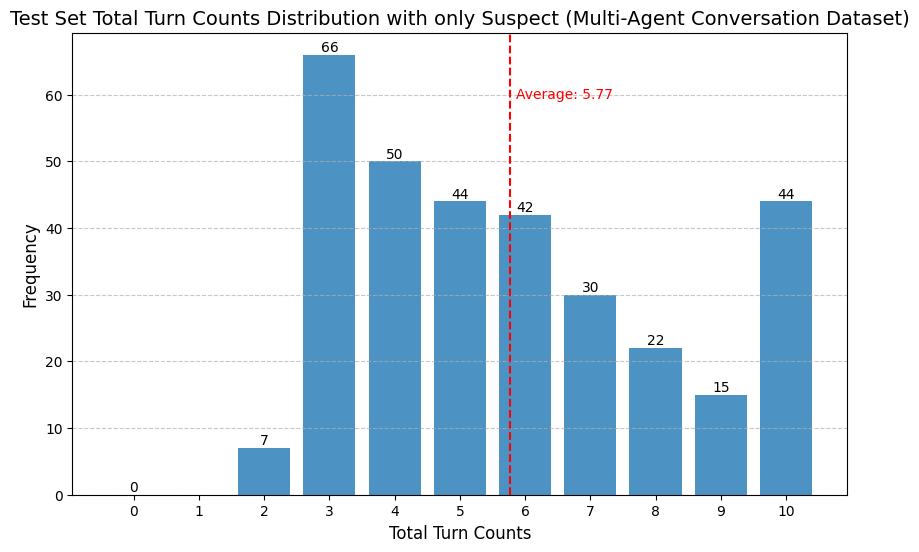

Test Result from training with above distribution

In [ ]:
# Function to filter only the Suspect's dialogue
def filter_suspect_dialogue(dialogue):
    parts = dialogue.split(' ')
    suspect_dialogue = []
    is_suspect = False
    for part in parts:
        if part.startswith('Suspect:'):
            is_suspect = True
        elif part.startswith('Innocent:'):
            is_suspect = False
        if is_suspect:
            suspect_dialogue.append(part)
    return ' '.join(suspect_dialogue)

# Apply the function to the DataFrame
train_df['dialogue'] = train_df['dialogue'].apply(filter_suspect_dialogue)
test_df['dialogue'] = test_df['dialogue'].apply(filter_suspect_dialogue)

# Convert train and test dataframes to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

print(len(train_df))
print(len(test_df))

1280
320


In [ ]:
pd.set_option('display.max_colwidth', None)
train_df.head(2)

,dialogue,personality,labels,suspect_turns,innocent_turns,total_turns
0,"Suspect: Hi, this is Karen from Smith & Co. I'm calling to confirm your appointment with Dr. Lee on Thursday at 2 PM. Can you please confirm that you're still available to come in at that time? Suspect: I understand your concern, Mr. Johnson. I apologize if we've had any last-minute changes in the past. However, I assure you that this call is just a routine confirmation to ensure you're still able to make the appointment. We want to make sure we're both on the same page and avoid any misunderstandings. Can you please confirm your availability for Thursday at 2 PM? Suspect: I understand your frustration, Mr. Johnson. To be honest, Dr. Lee is running a bit behind schedule, and we're trying to adjust the appointments accordingly. Would you be available to come in an hour earlier, at 1 PM, instead of 2 PM? Suspect: I understand, Mr. Johnson. I apologize again for the inconvenience. I'll make sure to note that you're still confirmed for 2 PM on Thursday. I'll also let Dr. Lee's office know that you're not flexible with the time. We'll do our best to accommodate your original appointment time. Suspect: Understood, Mr. Johnson. I'll make sure Dr. Lee is aware of your expectations. I'll also put a note on your file to ensure you're seen promptly at 2 PM. Thank you for your time, and I'll let you go. Goodbye.",aggressive,0,5,0,5
1,"Suspect: Hi, this is Karen from Smith's Medical Group. I'm calling to confirm your appointment with Dr. Johnson on Friday at 2 PM. Can you confirm that you're still able to make it? Suspect: I understand your concern, Mr. Thompson. I apologize if we've had any delays in the past. I just need to confirm that you're still available to come in on Friday at 2 PM. If you're not, we can work together to find a new time that suits you better. Suspect: I understand your frustration, Mr. Thompson. I'm not here to make excuses, but I want to assure you that Dr. Johnson is committed to providing you with the best care possible. Regarding your appointment, if you're not comfortable keeping it, I can offer you a few alternative times. Would you like to reschedule for a different day or time? Suspect: I understand your concern about the wait time, Mr. Thompson. I can check on the availability of earlier appointments. Let me check with our scheduling team real quick. Okay, I've checked and it looks like we had a cancellation for tomorrow afternoon. Would you like to come in then instead of waiting until Friday? Suspect: I understand your frustration, Mr. Thompson. I'm going to pass on your feedback to our office management so we can work on improving our scheduling process. In the meantime, I still need to confirm your appointment for Friday. Are you still planning to keep it?",aggressive,0,5,0,5


### Train model with limit turn

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = evaluate.load("accuracy")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels),
        "precision": precision.compute(predictions=predictions, references=labels, average="weighted"),
        "recall": recall.compute(predictions=predictions, references=labels, average="weighted"),
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")
    }

import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl, EarlyStoppingCallback

class PlotLossesCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs and logs['eval_accuracy'] == 1.0:
                control.should_training_stop = True

    def on_train_end(self, args, state, control, **kwargs):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.eval_losses, label="Validation Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        if self.train_losses:
            plt.ylim(bottom=0, top=self.train_losses[0])  # Set top limit to the first training loss
        plt.legend()
        plt.title("Training and Validation Loss over Time")
        plt.show()

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.011826,{'accuracy': 0.996875},{'precision': 0.996894409937888},{'recall': 0.996875},{'f1': 0.9968749694821237}
2,No log,0.010719,{'accuracy': 0.996875},{'precision': 0.996894409937888},{'recall': 0.996875},{'f1': 0.9968749694821237}
3,No log,0.009112,{'accuracy': 0.996875},{'precision': 0.996894409937888},{'recall': 0.996875},{'f1': 0.9968749694821237}
4,0.030400,0.018176,{'accuracy': 0.996875},{'precision': 0.996894409937888},{'recall': 0.996875},{'f1': 0.9968749694821237}
5,0.030400,0.018831,{'accuracy': 0.996875},{'precision': 0.996894409937888},{'recall': 0.996875},{'f1': 0.9968749694821237}


Trainer is attempting to log a value of "{'accuracy': 0.996875}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.996894409937888}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.996875}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9968749694821237}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.996875}" of type <class 'dict'> for key "eval/accuracy"

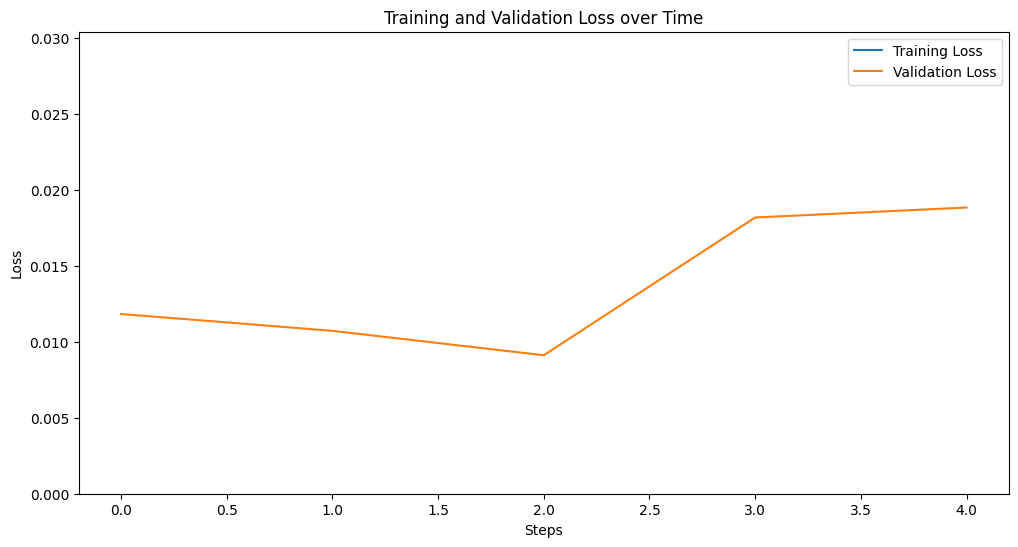

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

def train_bert():
    bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

    def bert_preprocess_function(examples):
        return bert_tokenizer(examples["dialogue"], truncation=True, padding=True)

    bert_tokenized_dataset = dataset.map(bert_preprocess_function, batched=True)
    bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

    id2label = {0: "NON-SCAM", 1: "SCAM"}
    label2id = {"NON-SCAM": 0, "SCAM": 1}

    model = AutoModelForSequenceClassification.from_pretrained(
        "google-bert/bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir="bert-agent-suspect-only-scam-classifier-v1.0",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=20,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=bert_tokenized_dataset['train'],
        eval_dataset=bert_tokenized_dataset['test'],
        tokenizer=bert_tokenizer,
        data_collator=bert_data_collator,
        compute_metrics=compute_metrics,
        callbacks=[
            PlotLossesCallback(),
            EarlyStoppingCallback(early_stopping_threshold=0.01, early_stopping_patience=4)
        ]
    )

    trainer.train()
    trainer.push_to_hub()

train_bert()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert train and test dataframes to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["dialogue"], padding=True, truncation=True)

# Tokenize the datasets
train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Set the format for the datasets
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

data_collator  = DataCollatorWithPadding(tokenizer=tokenizer) #The collator rename the column label to labels

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=data_collator)
val_loader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=data_collator)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer, patience=3, threshold=0.01):
    best_val_loss = None
    best_model = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    first_epoch = True

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        model.eval()
        val_running_loss = 0.0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        if first_epoch or val_loss < best_val_loss - best_val_loss * threshold:
            best_val_loss = val_loss
            best_model = model
            epochs_no_improve = 0
            first_epoch = False
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} consecutive epochs.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return best_model, best_val_loss


Training Model 1
Epoch [1/16], Training Loss: 2.0276
Validation Loss: 1.7734, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5672
Validation Loss: 1.3748, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.1946
Validation Loss: 1.1207, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.3075
Validation Loss: 1.1893, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.3416
Validation Loss: 1.3891, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.2820
Validation Loss: 1.3044, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


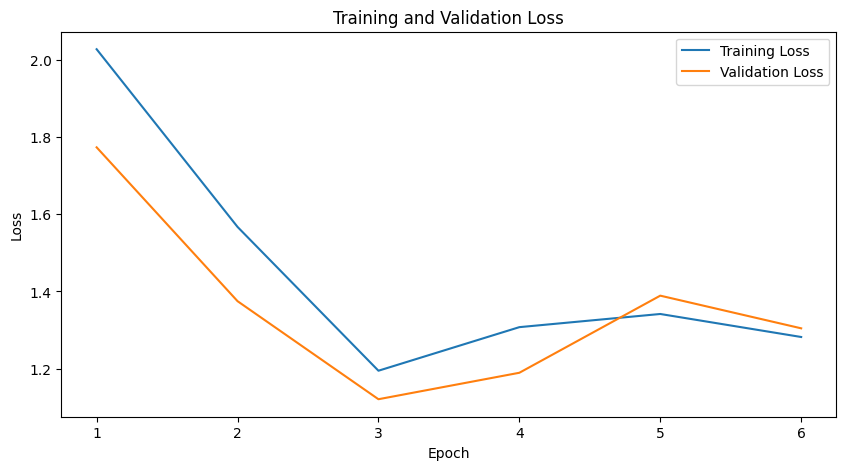

Training Model 2
Epoch [1/16], Training Loss: 2.0008
Validation Loss: 1.5326, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5502
Validation Loss: 1.3518, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.3627
Validation Loss: 1.2326, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.2270
Validation Loss: 1.3802, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.1376
Validation Loss: 1.2119, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.1376
Validation Loss: 0.9763, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 0.9762
Validation Loss: 0.8750, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.9304
Validation Loss: 0.8372, Accur

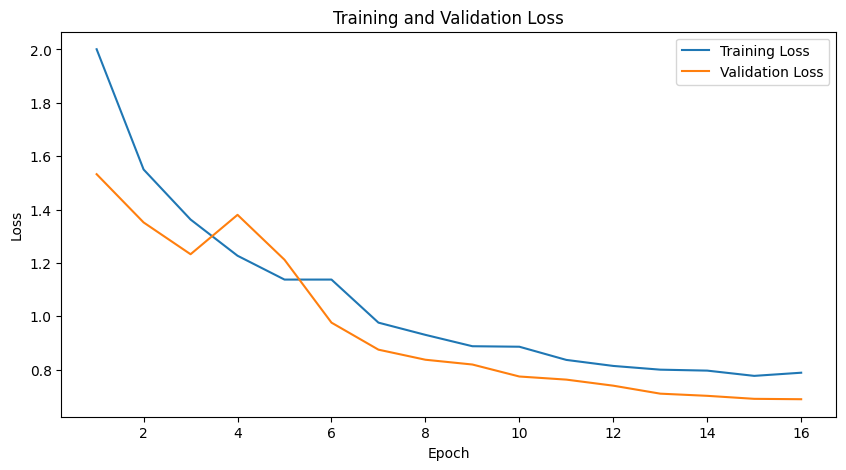

Training Model 3
Epoch [1/16], Training Loss: 2.0214
Validation Loss: 1.5103, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.3503
Validation Loss: 0.9198, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.1372
Validation Loss: 0.8846, Accuracy: 0.7375, Precision: 0.6597, Recall: 0.9812, F1 Score: 0.7889
Epoch [4/16], Training Loss: 1.0776
Validation Loss: 1.0881, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 0.9803
Validation Loss: 0.9568, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.0284
Validation Loss: 0.8742, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 0.9253
Validation Loss: 0.7998, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.8731
Validation Loss: 0.7602, Accur

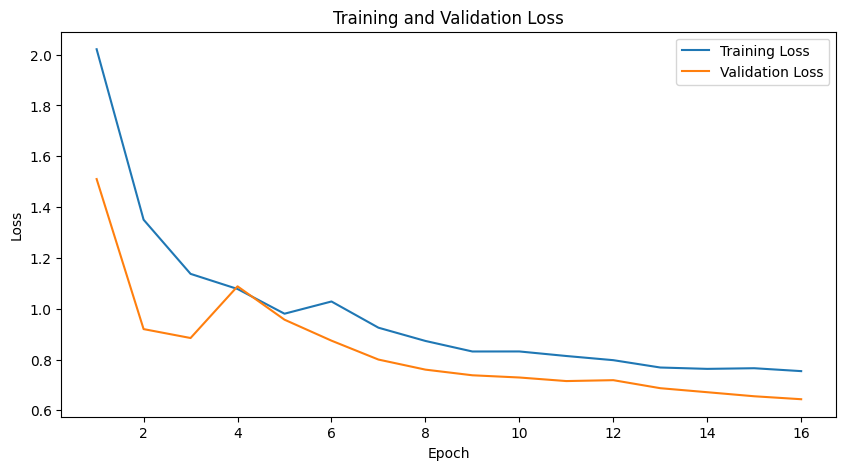

Training Model 4
Epoch [1/16], Training Loss: 2.0607
Validation Loss: 1.5054, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.6343
Validation Loss: 1.5536, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.5060
Validation Loss: 1.3238, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.3071
Validation Loss: 1.2559, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.0782
Validation Loss: 1.1293, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.0847
Validation Loss: 1.0202, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 1.0357
Validation Loss: 0.9020, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.9811
Validation Loss: 0.8541, Accur

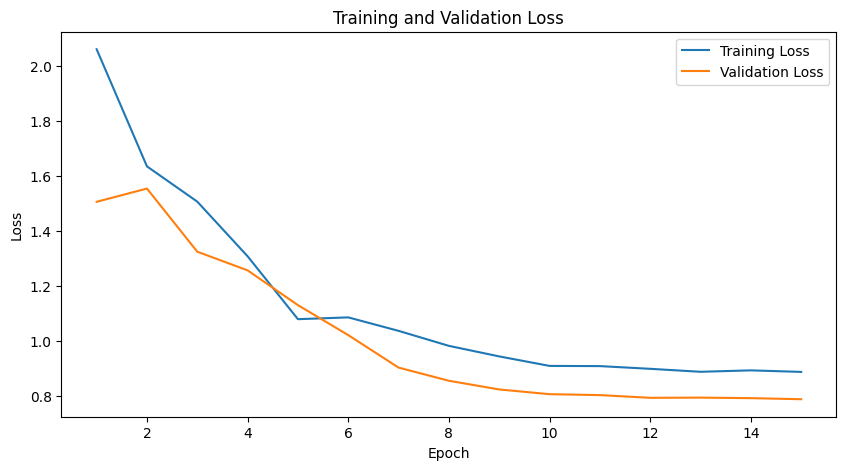

Training Model 5
Epoch [1/16], Training Loss: 2.0628
Validation Loss: 1.8001, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5446
Validation Loss: 1.3721, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.2953
Validation Loss: 1.2966, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 0.8585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.5911, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.4369
Validation Loss: 0.9873, Accuracy: 0.6875, Precision: 0.6163, Recall: 0.9938, F1 Score: 0.7608
Epoch [6/16], Training Loss: 0.9048
Validation Loss: 0.8796, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 0.8292
Validation Loss: 0.7937, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.9418
Validation Loss: 0.7643, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [9/16], Training Loss: 0.8669
Validation Loss: 0.7313, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [10/16], Training Loss: 0.8251
Validation Loss: 0.7000, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [11/16], Training Loss: 0.7963
Validation Loss: 0.6822, Accuracy: 0.7438, Precision: 0.6681, Recall: 0.9688, F1 

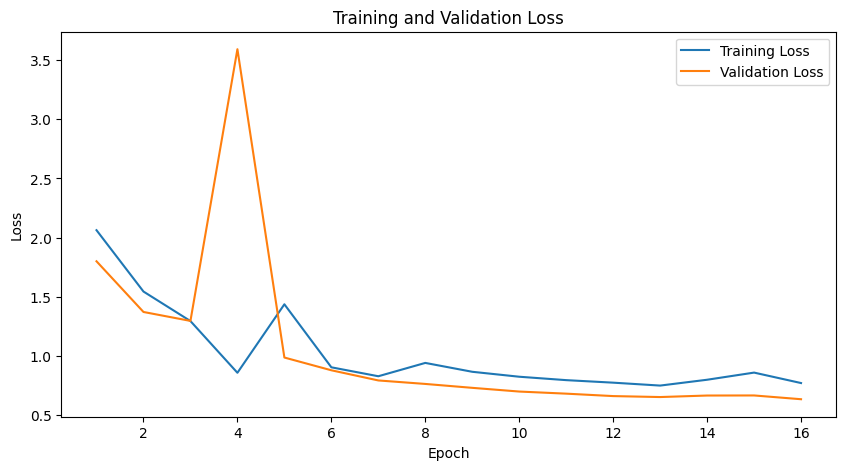

Training Model 6
Epoch [1/16], Training Loss: 2.0816
Validation Loss: 1.5990, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5597
Validation Loss: 1.2853, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.2258
Validation Loss: 1.2336, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.0356
Validation Loss: 1.0440, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.0774
Validation Loss: 0.9487, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.0190
Validation Loss: 0.8908, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 0.9775
Validation Loss: 0.8850, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.9578
Validation Loss: 0.8574, Accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 5.0968, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [10/16], Training Loss: 1.9261


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.8940, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [11/16], Training Loss: 1.5468
Validation Loss: 1.6341, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


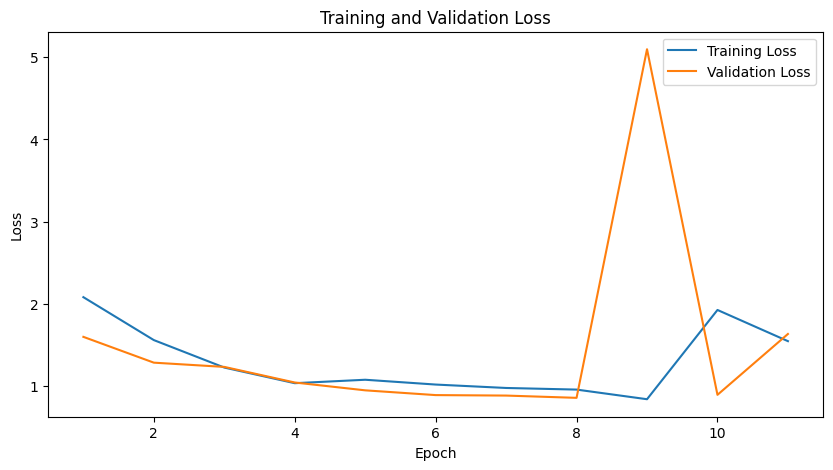

Training Model 7
Epoch [1/16], Training Loss: 1.9385
Validation Loss: 1.4238, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.6250
Validation Loss: 1.3953, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.4021
Validation Loss: 0.9185, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.3206
Validation Loss: 1.1922, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.1328
Validation Loss: 1.2304, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.2163
Validation Loss: 1.0301, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


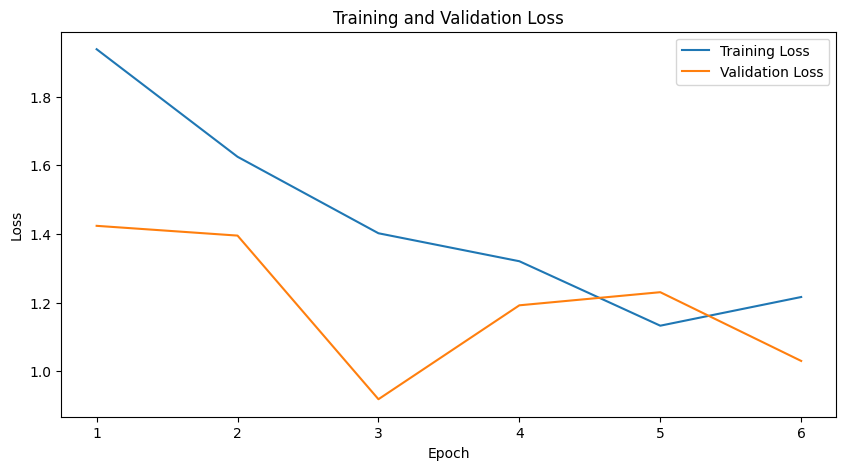

Training Model 8
Epoch [1/16], Training Loss: 2.0765
Validation Loss: 1.5169, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.6213
Validation Loss: 1.3213, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.2282
Validation Loss: 0.5929, Accuracy: 0.6750, Precision: 0.7800, Recall: 0.4875, F1 Score: 0.6000
Epoch [4/16], Training Loss: 1.4978
Validation Loss: 1.2262, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.2736
Validation Loss: 1.1027, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.0886
Validation Loss: 1.1301, Accuracy: 0.7406, Precision: 0.6638, Recall: 0.9750, F1 Score: 0.7899
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


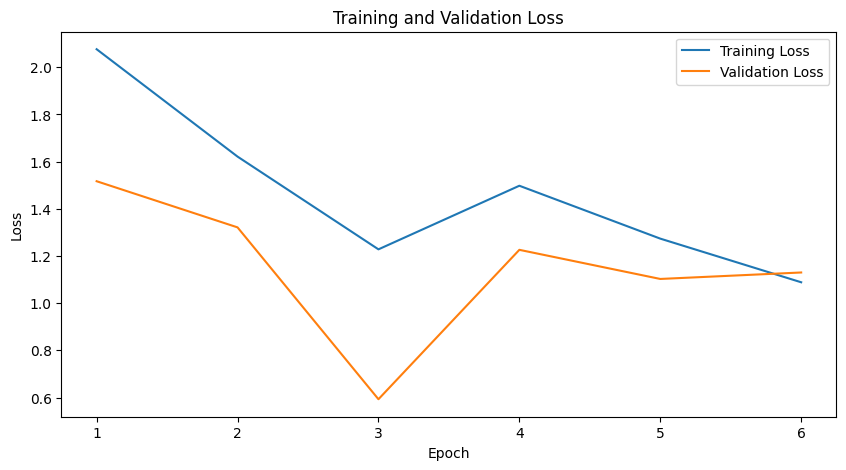

Training Model 9
Epoch [1/16], Training Loss: 2.0427
Validation Loss: 1.7806, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5364
Validation Loss: 1.3838, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.2309
Validation Loss: 1.1917, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.1346
Validation Loss: 1.1645, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.3607
Validation Loss: 1.4104, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.3170
Validation Loss: 1.2083, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 1.1481
Validation Loss: 1.1845, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 

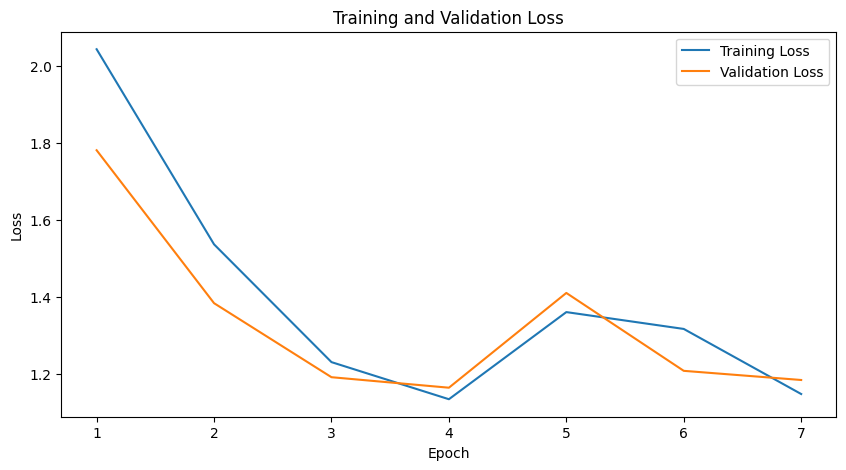

Training Model 10
Epoch [1/16], Training Loss: 2.0560
Validation Loss: 1.7197, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.5634
Validation Loss: 1.4284, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.2302
Validation Loss: 1.1693, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 0.9979
Validation Loss: 1.0152, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 0.9971
Validation Loss: 0.8926, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.0085
Validation Loss: 0.8497, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [7/16], Training Loss: 0.9323
Validation Loss: 0.8888, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [8/16], Training Loss: 0.9037
Validation Loss: 0.8693, Accu

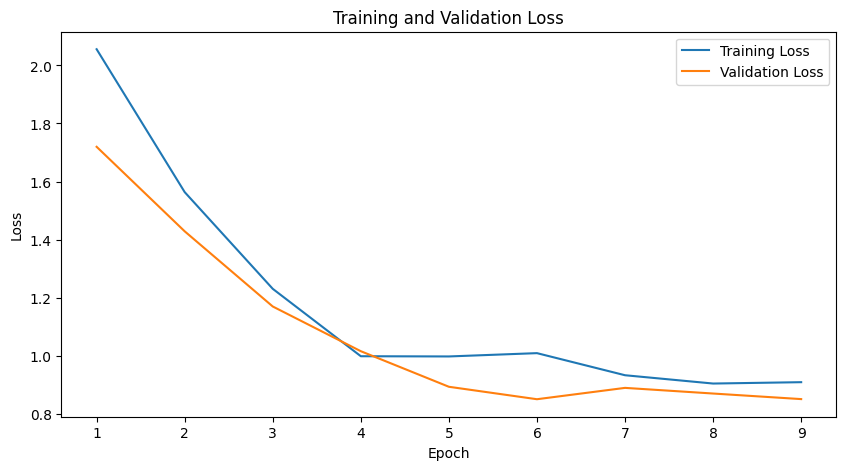

model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.5929017752408982.


In [ ]:
import torch
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

# Define the LSTM model class
class LSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, model_type="lstm"):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Train models
best_val_loss = float('inf')
best_model_state_dict = None

for model_num in range(10):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "lstm-agent-suspect-only-scam-classifier-v1.0.pt")
    # Create a new instance of the best model
    best_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("lstm-agent-suspect-only-scam-classifier-v1.0")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

Training Model 1
Epoch [1/16], Training Loss: 2.0173
Validation Loss: 0.7043, Accuracy: 0.7063, Precision: 0.7750, Recall: 0.5813, F1 Score: 0.6643
Epoch [2/16], Training Loss: 1.7026
Validation Loss: 0.7436, Accuracy: 0.6781, Precision: 0.7879, Recall: 0.4875, F1 Score: 0.6023
Epoch [3/16], Training Loss: 1.6345
Validation Loss: 1.2378, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.4672
Validation Loss: 1.0584, Accuracy: 0.7438, Precision: 0.6667, Recall: 0.9750, F1 Score: 0.7919
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


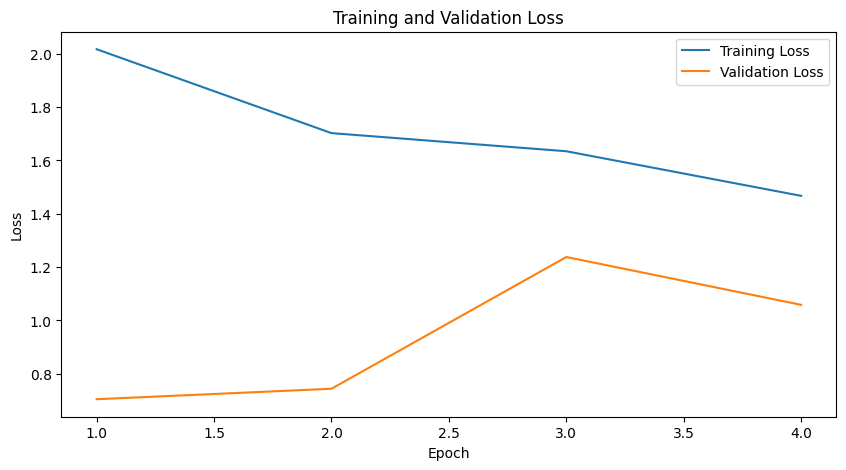

Training Model 2
Epoch [1/16], Training Loss: 2.1424
Validation Loss: 0.7284, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 2.0496
Validation Loss: 1.0891, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.9953
Validation Loss: 0.8408, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 2.4886
Validation Loss: 1.4119, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


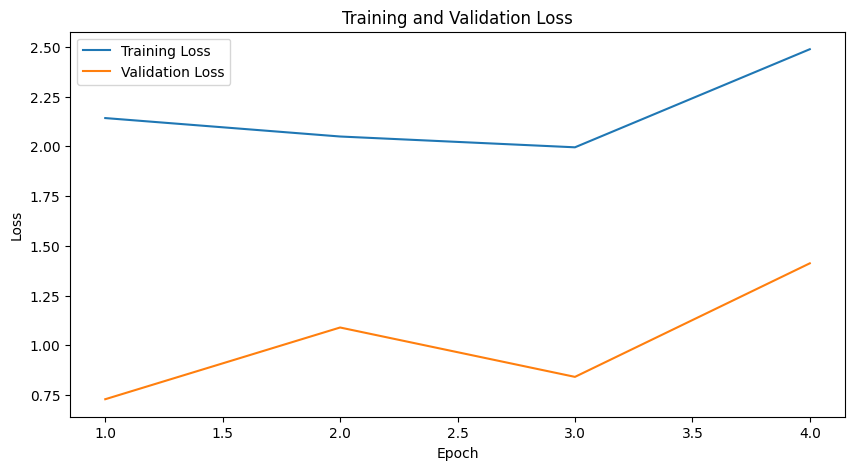

Training Model 3
Epoch [1/16], Training Loss: 1.9602
Validation Loss: 0.9118, Accuracy: 0.7125, Precision: 0.7742, Recall: 0.6000, F1 Score: 0.6761
Epoch [2/16], Training Loss: 1.0993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.0396, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.9820
Validation Loss: 0.9026, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [4/16], Training Loss: 1.2328
Validation Loss: 1.1049, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.2652
Validation Loss: 1.1169, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [6/16], Training Loss: 1.2585
Validation Loss: 1.0214, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


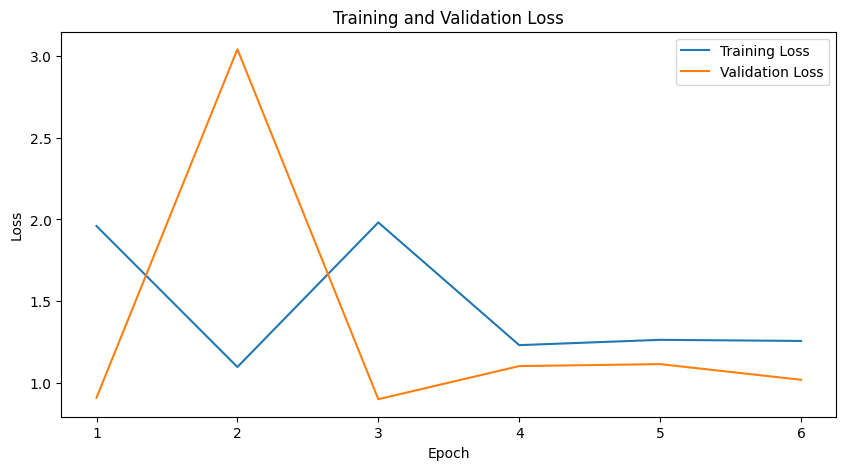

Training Model 4
Epoch [1/16], Training Loss: 1.9826
Validation Loss: 0.9463, Accuracy: 0.6719, Precision: 0.7670, Recall: 0.4938, F1 Score: 0.6008
Epoch [2/16], Training Loss: 1.5616


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.8131, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 2.2171
Validation Loss: 1.6893, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.5759
Validation Loss: 1.3597, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


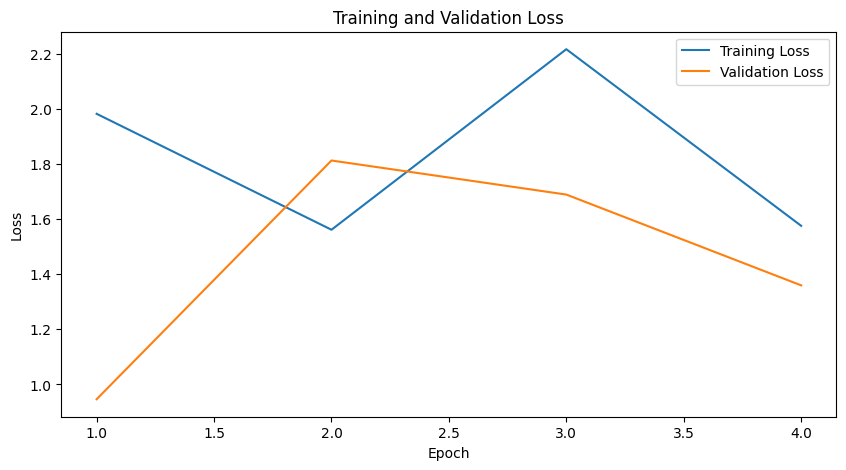

Training Model 5
Epoch [1/16], Training Loss: 2.0752
Validation Loss: 0.6618, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 2.1233
Validation Loss: 1.0358, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 2.1063
Validation Loss: 1.4379, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.9610
Validation Loss: 0.8624, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


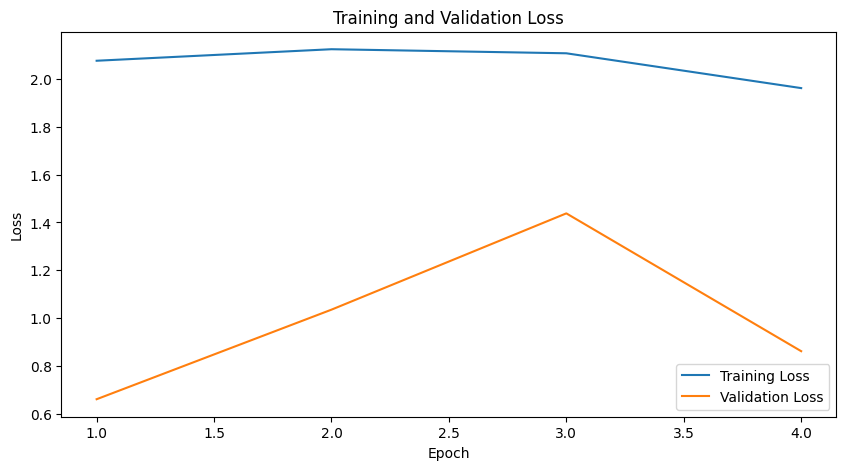

Training Model 6
Epoch [1/16], Training Loss: 2.0902
Validation Loss: 0.6979, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.8938


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2279, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 2.7322
Validation Loss: 3.0995, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 2.9172
Validation Loss: 1.6853, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


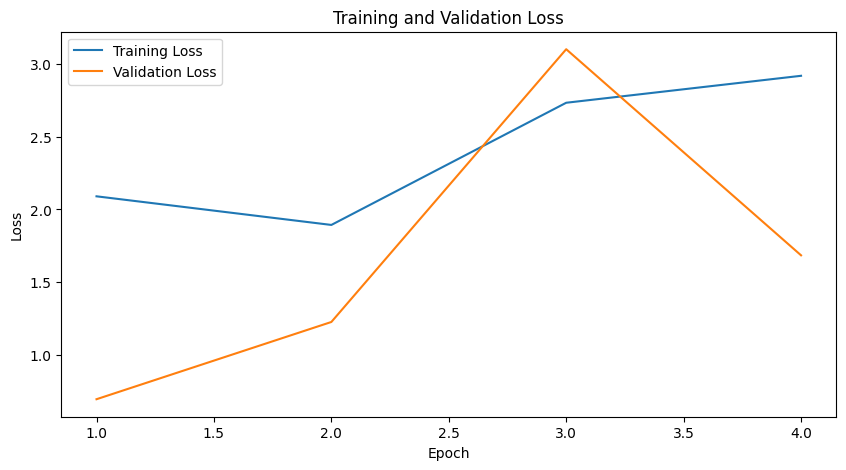

Training Model 7
Epoch [1/16], Training Loss: 2.1429
Validation Loss: 0.8078, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.8511
Validation Loss: 1.2146, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.8555
Validation Loss: 1.6528, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.4504
Validation Loss: 1.3447, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


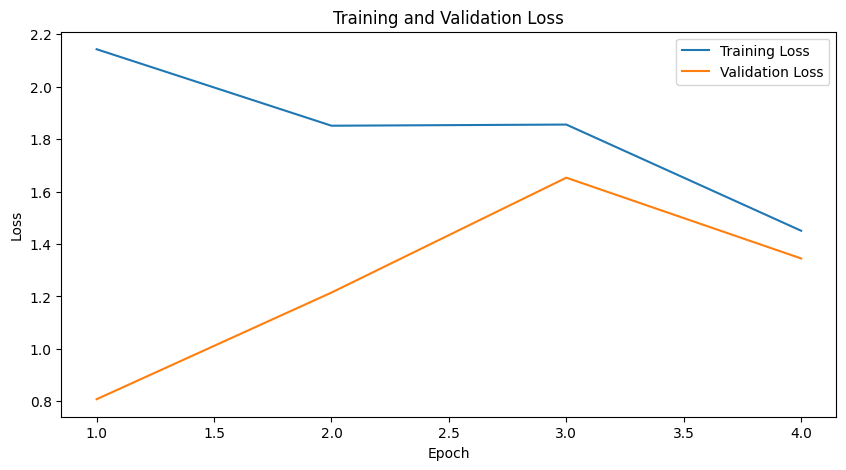

Training Model 8
Epoch [1/16], Training Loss: 2.0868
Validation Loss: 0.8266, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 1.7982
Validation Loss: 0.8610, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.8462
Validation Loss: 1.6955, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.7714
Validation Loss: 1.5204, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


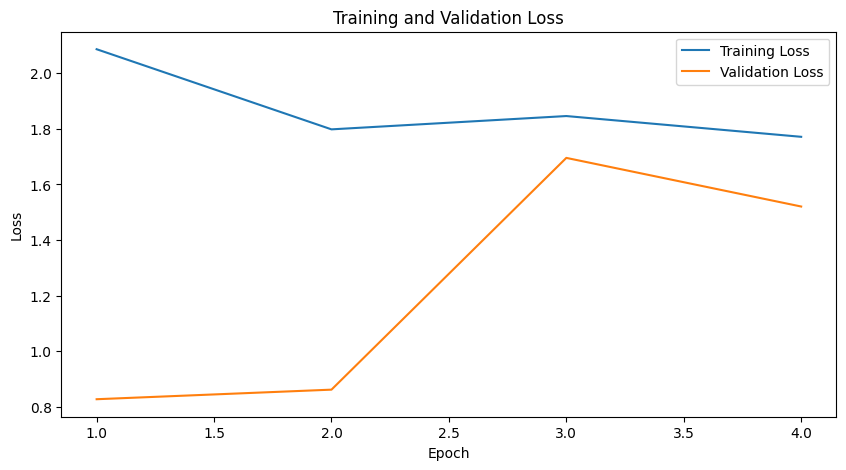

Training Model 9
Epoch [1/16], Training Loss: 2.1397
Validation Loss: 0.7772, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 2.2668
Validation Loss: 0.6724, Accuracy: 0.6750, Precision: 0.7800, Recall: 0.4875, F1 Score: 0.6000
Epoch [3/16], Training Loss: 2.2516
Validation Loss: 1.5146, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 2.2541
Validation Loss: 1.5073, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [5/16], Training Loss: 1.3308
Validation Loss: 0.9437, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


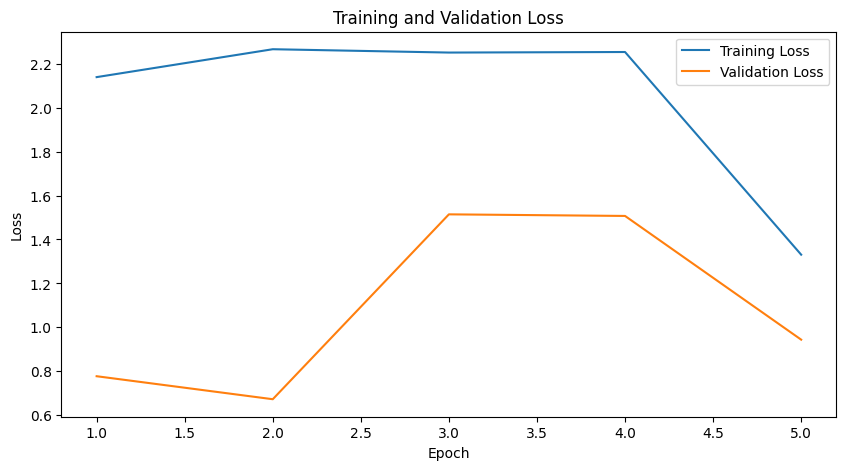

Training Model 10
Epoch [1/16], Training Loss: 2.0804
Validation Loss: 0.8331, Accuracy: 0.6750, Precision: 0.7800, Recall: 0.4875, F1 Score: 0.6000
Epoch [2/16], Training Loss: 1.8416
Validation Loss: 0.7877, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.8937
Validation Loss: 1.1346, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 1.7007
Validation Loss: 1.4260, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.3914
Validation Loss: 1.2786, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


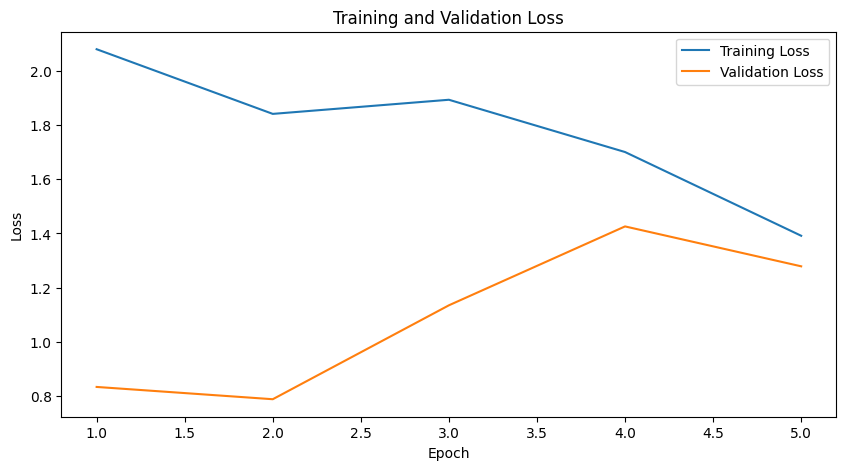

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.6618488430976868.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin
# Define the LSTM model class
class BiLSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiLSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(10):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "bilstm-agent-suspect-only-scam-classifier-v1.0.pt")
    # Create a new instance of the best model
    best_model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("bilstm-agent-suspect-only-scam-classifier-v1.0")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

Training Model 1
Epoch [1/16], Training Loss: 0.8124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.7229, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 2.3596


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.9319, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.2506


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.2068, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 2.0887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.0309, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.1952
Validation Loss: 2.6668, Accuracy: 0.6687, Precision: 0.8000, Recall: 0.4500, F1 Score: 0.5760
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


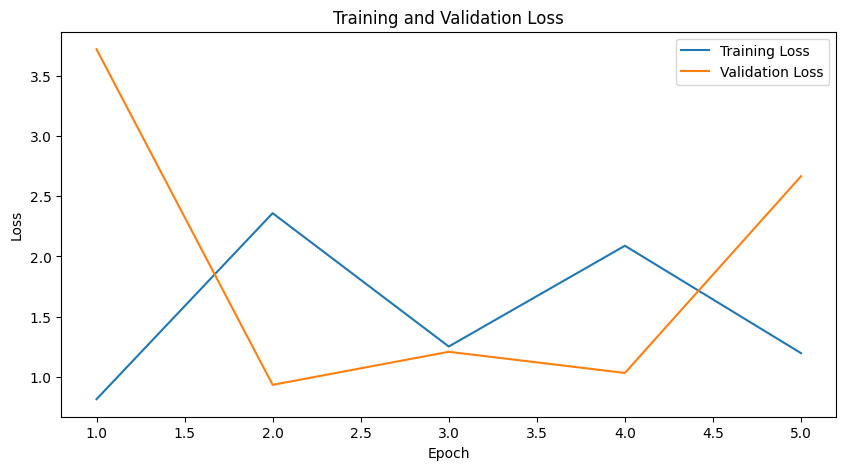

Training Model 2
Epoch [1/16], Training Loss: 0.8151


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.7744, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 1.9689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.8266, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.5766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.3982, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 0.6894
Validation Loss: 2.0618, Accuracy: 0.6750, Precision: 0.7800, Recall: 0.4875, F1 Score: 0.6000
Epoch [5/16], Training Loss: 0.9053
Validation Loss: 2.3952, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/16], Training Loss: 2.1501
Validation Loss: 0.8813, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [7/16], Training Loss: 2.9955
Validation Loss: 1.0640, Accuracy: 0.6750, Precision: 0.7800, Recall: 0.4875, F1 Score: 0.6000
Epoch [8/16], Training Loss: 2.6363
Validation Loss: 1.6301, Accuracy: 0.6750, Precision: 0.7857, Recall: 0.4813, F1 Score: 0.5969
Epoch [9/16], Training Loss: 1.8971
Validation Loss: 2.0625, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


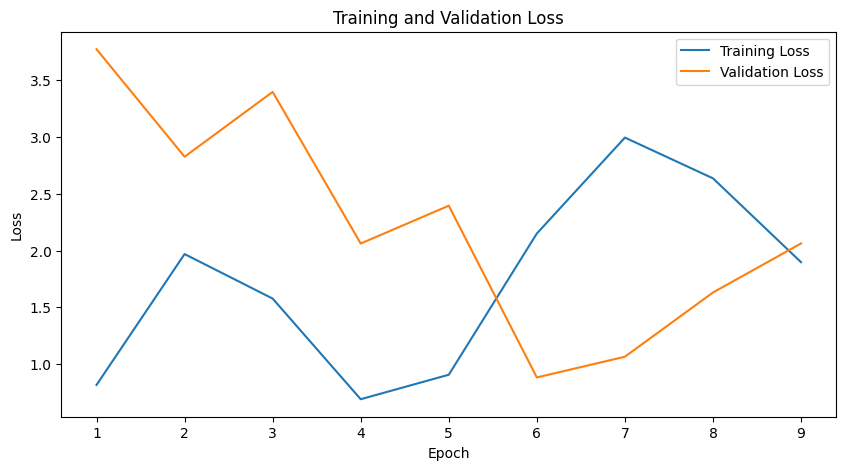

Training Model 3
Epoch [1/16], Training Loss: 0.8080


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.7646, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 3.3010
Validation Loss: 2.5534, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.1730


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.2397, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 1.9233
Validation Loss: 1.1512, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 1.4761
Validation Loss: 1.3209, Accuracy: 0.6344, Precision: 0.6029, Recall: 0.7875, F1 Score: 0.6829
Epoch [6/16], Training Loss: 0.4733
Validation Loss: 1.2186, Accuracy: 0.7562, Precision: 0.6752, Recall: 0.9875, F1 Score: 0.8020
Epoch [7/16], Training Loss: 0.4676
Validation Loss: 4.0721, Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1 Score: 0.7273
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


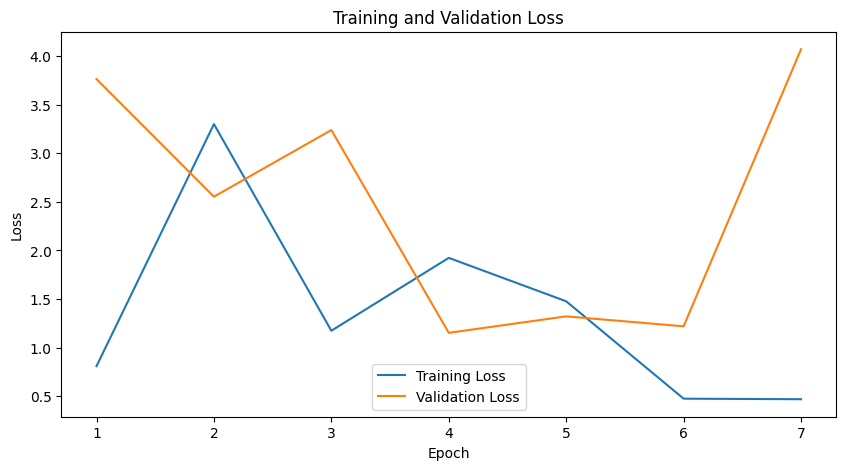

Training Model 4
Epoch [1/16], Training Loss: 0.8613


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.7495, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 2.1819


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.1299, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.3259


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.3146, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 3.3762
Validation Loss: 0.8741, Accuracy: 0.6062, Precision: 0.5594, Recall: 1.0000, F1 Score: 0.7175
Epoch [5/16], Training Loss: 2.5086
Validation Loss: 1.1999, Accuracy: 0.6219, Precision: 0.5699, Recall: 0.9938, F1 Score: 0.7244
Epoch [6/16], Training Loss: 1.9530
Validation Loss: 2.4471, Accuracy: 0.6188, Precision: 0.5693, Recall: 0.9750, F1 Score: 0.7189
Epoch [7/16], Training Loss: 0.6388
Validation Loss: 4.8765, Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1 Score: 0.7273
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


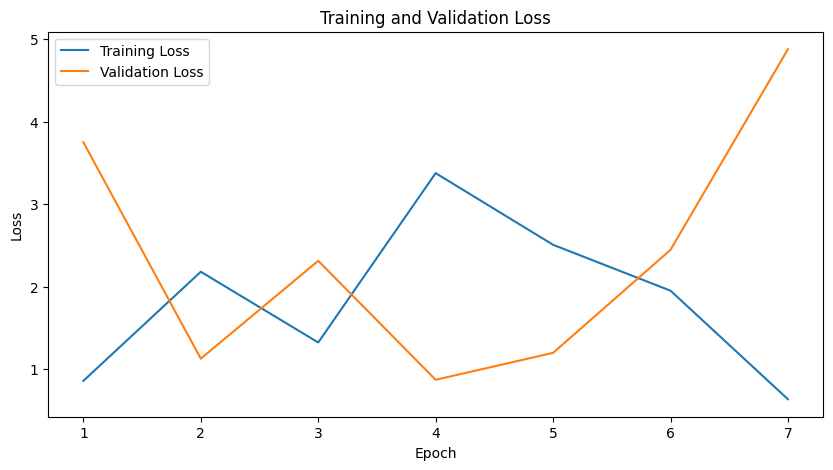

Training Model 5
Epoch [1/16], Training Loss: 0.8021


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.4397, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 1.9423


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.2207, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.3254


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.5844, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 1.5385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 4.7323, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.2151


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.4788, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


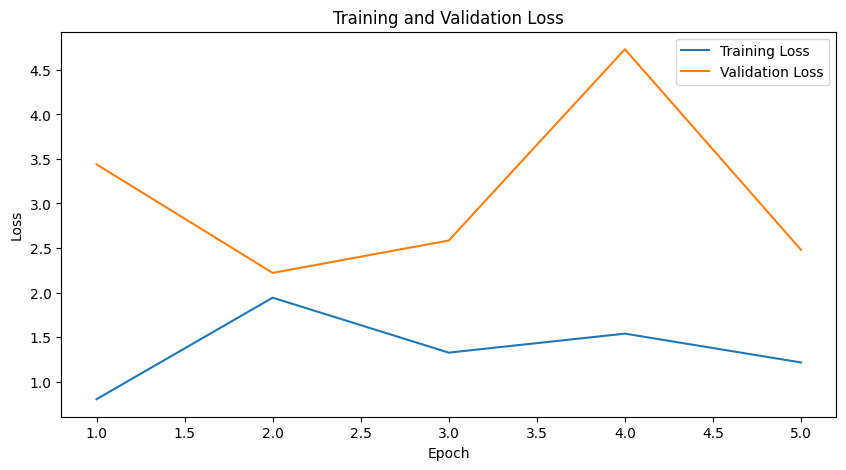

Training Model 6
Epoch [1/16], Training Loss: 0.8270


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.5680, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 2.7456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.1209, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 2.9254


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.1980, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 2.8269
Validation Loss: 0.9747, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/16], Training Loss: 0.8114
Validation Loss: 1.7081, Accuracy: 0.6125, Precision: 1.0000, Recall: 0.2250, F1 Score: 0.3673
Epoch [6/16], Training Loss: 1.3684


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.3062, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [7/16], Training Loss: 1.0683
Validation Loss: 1.4317, Accuracy: 0.5844, Precision: 0.6031, Recall: 0.4938, F1 Score: 0.5430
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


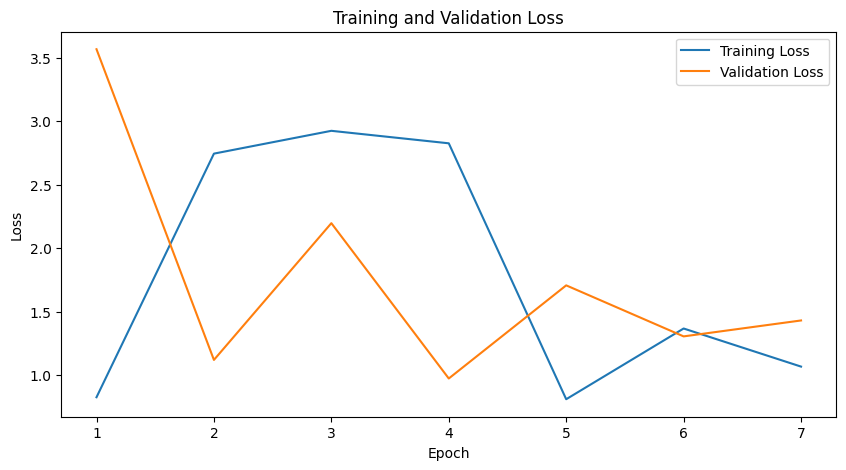

Training Model 7
Epoch [1/16], Training Loss: 0.8886


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.8055, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 2.6390


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.1723, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 2.2745
Validation Loss: 0.9678, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 0.9419


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.8953, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.0103
Validation Loss: 0.5885, Accuracy: 0.7844, Precision: 0.7758, Recall: 0.8000, F1 Score: 0.7877
Epoch [6/16], Training Loss: 1.4603


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.5333, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [7/16], Training Loss: 0.9941
Validation Loss: 2.0215, Accuracy: 0.5219, Precision: 0.5814, Recall: 0.1562, F1 Score: 0.2463
Epoch [8/16], Training Loss: 0.5053
Validation Loss: 2.5424, Accuracy: 0.6719, Precision: 0.7895, Recall: 0.4688, F1 Score: 0.5882
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


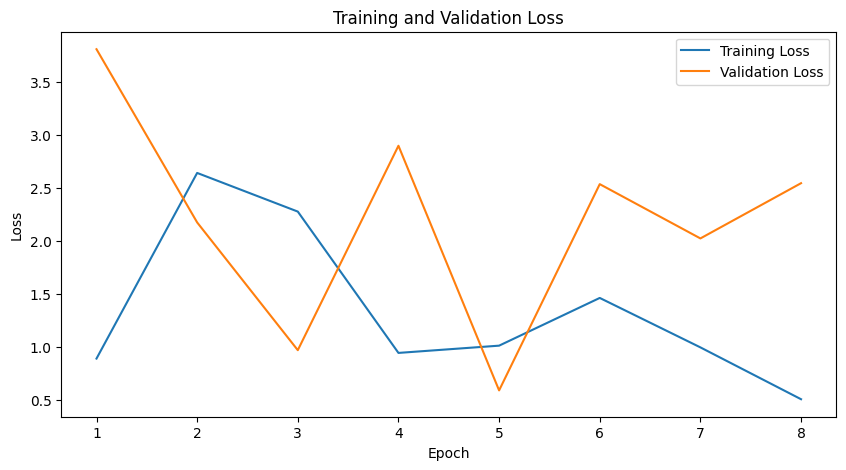

Training Model 8
Epoch [1/16], Training Loss: 0.8716


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.4091, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 3.3545
Validation Loss: 1.4224, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 1.3978


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 4.0556, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 1.0460
Validation Loss: 1.2493, Accuracy: 0.3969, Precision: 0.3146, Recall: 0.1750, F1 Score: 0.2249
Epoch [5/16], Training Loss: 0.6827
Validation Loss: 2.1997, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/16], Training Loss: 0.8994
Validation Loss: 2.5772, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [7/16], Training Loss: 1.6084
Validation Loss: 2.0475, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


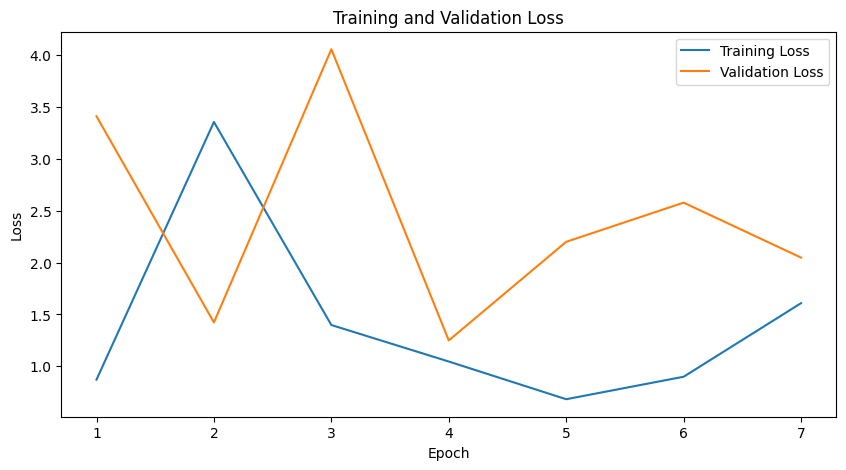

Training Model 9
Epoch [1/16], Training Loss: 0.7438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.4050, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 1.1323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.1763, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/16], Training Loss: 1.6835


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.9946, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/16], Training Loss: 0.6992


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.8692, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.2562
Validation Loss: 2.4436, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/16], Training Loss: 0.6836


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.4769, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [7/16], Training Loss: 1.1033
Validation Loss: 2.5616, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [8/16], Training Loss: 0.6174
Validation Loss: 1.6590, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [9/16], Training Loss: 1.1879
Validation Loss: 0.9221, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [10/16], Training Loss: 1.0184
Validation Loss: 1.2438, Accuracy: 0.7812, Precision: 0.7812, Recall: 0.7812, F1 Score: 0.7812
Epoch [11/16], Training Loss: 0.6828
Validation Loss: 0.6038, Accuracy: 0.8313, Precision: 0.7500, Recall: 0.9938, F1 Score: 0.8548
Epoch [12/16], Training Loss: 0.0674
Validation Loss: 1.2034, Accuracy: 0.7875, Precision: 0.7018, Recall: 1.0000, F1 Score: 0.8247
Epoch [13/16], Training Loss: 0.0684
Validation Loss: 1.1986, Accuracy: 0.7906, Precision: 0.7048, Recall: 1.0000, F

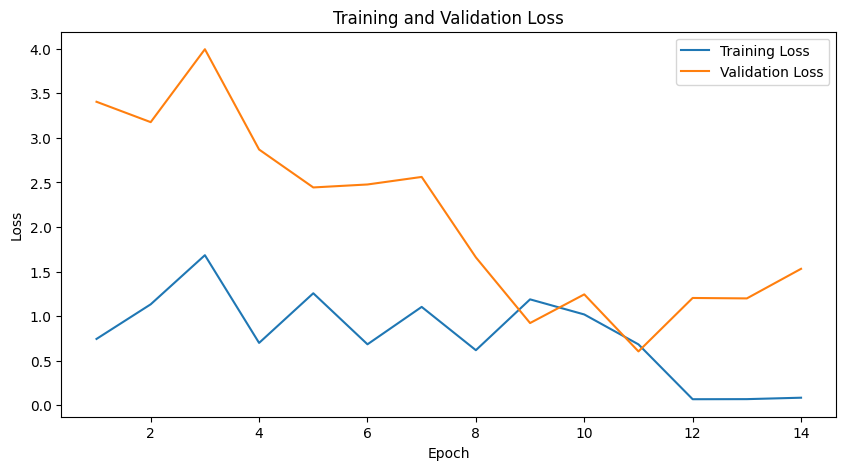

Training Model 10
Epoch [1/16], Training Loss: 1.0011


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.2452, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/16], Training Loss: 3.3256
Validation Loss: 0.7860, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/16], Training Loss: 3.7646
Validation Loss: 3.0349, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/16], Training Loss: 2.8775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 2.4769, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [5/16], Training Loss: 1.3912


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.6179, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


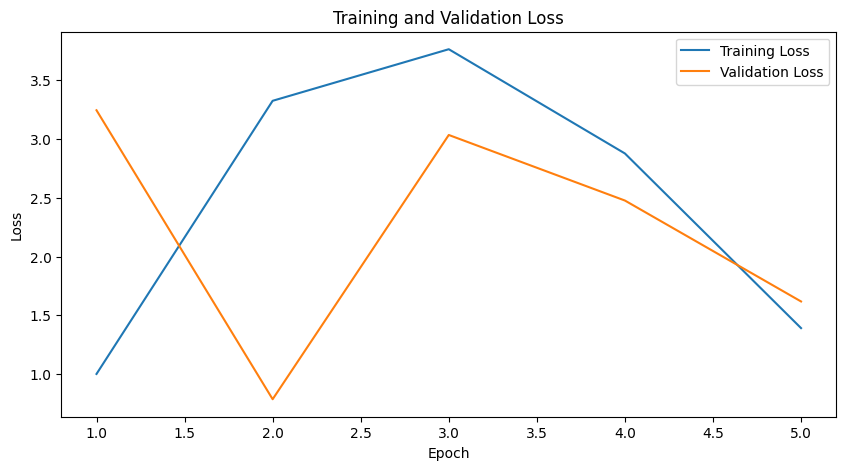

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.5884786525741219.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the GRU model class
class GRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(10):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = GRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "gru-agent-suspect-only-scam-classifier-v1.0.pt")
    # Create a new instance of the best model
    best_model = GRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("gru-agent-suspect-only-scam-classifier-v1.0")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

Training Model 1
Epoch [1/20], Training Loss: 1.1438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 5.6508, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/20], Training Loss: 1.7565


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 4.5749, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/20], Training Loss: 0.9059


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.5016, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [4/20], Training Loss: 1.5104
Validation Loss: 3.0866, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [5/20], Training Loss: 2.2007
Validation Loss: 3.2749, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/20], Training Loss: 2.5551
Validation Loss: 2.6699, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [7/20], Training Loss: 1.5711
Validation Loss: 3.7930, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [8/20], Training Loss: 1.3834
Validation Loss: 2.2163, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [9/20], Training Loss: 2.2442
Validation Loss: 1.9635, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [10/20], Training Loss: 2.5019
Validation Loss: 1.7303, Accuracy: 0.6844, Precision: 0.6148, Recall: 0.9875, F1 S

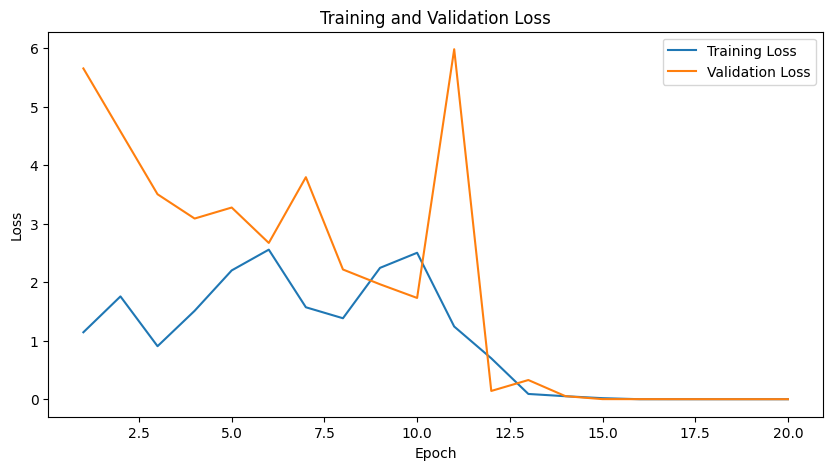

Training Model 2
Epoch [1/20], Training Loss: 1.0864


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 4.6197, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/20], Training Loss: 1.5617


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.5520, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/20], Training Loss: 1.2332
Validation Loss: 3.2532, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [4/20], Training Loss: 1.9106
Validation Loss: 4.1625, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [5/20], Training Loss: 0.6286
Validation Loss: 4.2768, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/20], Training Loss: 3.0703
Validation Loss: 1.7681, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [7/20], Training Loss: 3.8555
Validation Loss: 2.2134, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [8/20], Training Loss: 3.9732
Validation Loss: 1.9857, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [9/20], Training Loss: 3.5414
Validation Loss: 2.4307, Accuracy: 0.6062, Precision: 0.5620, Recall: 0.9625, F1 Sc

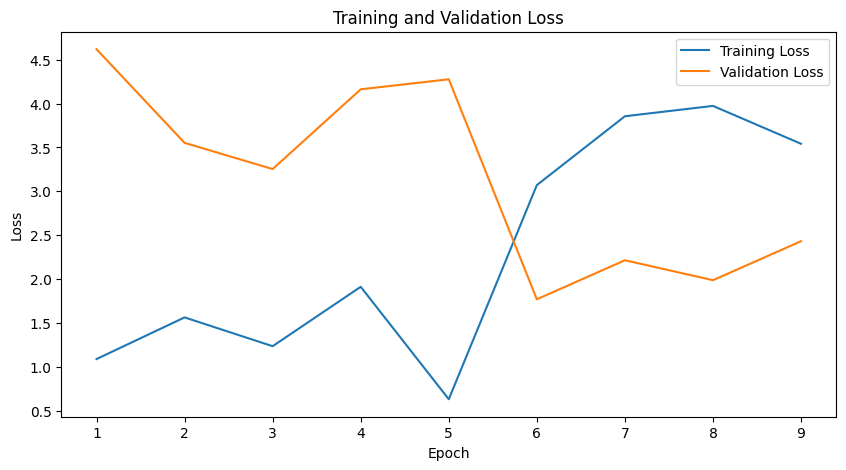

Training Model 3
Epoch [1/20], Training Loss: 1.2455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 4.8146, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/20], Training Loss: 1.0290


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 3.9285, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [3/20], Training Loss: 1.4523
Validation Loss: 2.9493, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [4/20], Training Loss: 1.5045
Validation Loss: 2.6934, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [5/20], Training Loss: 1.9668
Validation Loss: 2.4900, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [6/20], Training Loss: 2.0073
Validation Loss: 2.4623, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [7/20], Training Loss: 2.5426
Validation Loss: 2.0643, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [8/20], Training Loss: 1.5046
Validation Loss: 1.8722, Accuracy: 0.6781, Precision: 0.7938, Recall: 0.4813, F1 Score: 0.5992
Epoch [9/20], Training Loss: 0.5300
Validation Loss: 3.2286, Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1 Sc

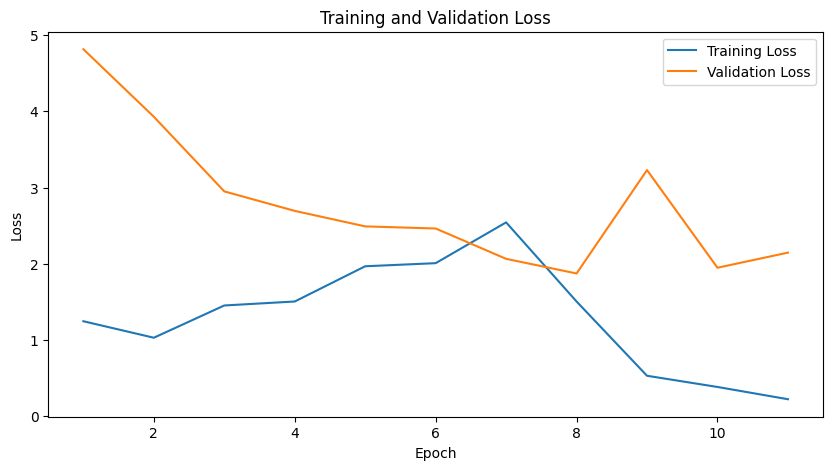

Training Model 4
Epoch [1/20], Training Loss: 1.1215


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 5.0765, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [2/20], Training Loss: 2.3360
Validation Loss: 0.8090, Accuracy: 0.6750, Precision: 0.7917, Recall: 0.4750, F1 Score: 0.5937
Epoch [3/20], Training Loss: 3.1682
Validation Loss: 1.9229, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [4/20], Training Loss: 2.8867
Validation Loss: 2.0452, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [5/20], Training Loss: 2.4911
Validation Loss: 1.7999, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


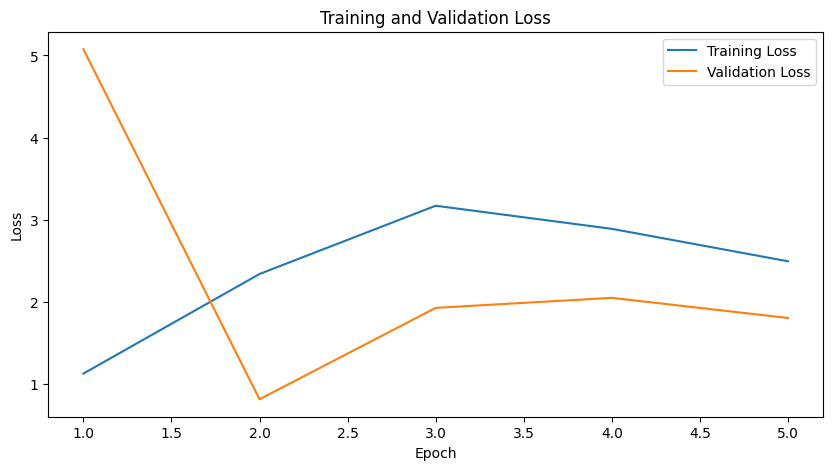

model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.0006449312294989796.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the BiGRU model class
class BiGRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiGRU
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 20
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(4):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = BiGRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "bigru-agent-suspect-only-scam-classifier-v1.0.pt")
    # Create a new instance of the best model
    best_model = BiGRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("bigru-agent-suspect-only-scam-classifier-v1.0")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

Training Model 1
Epoch [1/10], Training Loss: 2.0439
Validation Loss: 0.8405, Accuracy: 0.6531, Precision: 0.5904, Recall: 1.0000, F1 Score: 0.7425
Epoch [2/10], Training Loss: 1.3360
Validation Loss: 3.8924, Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1 Score: 0.7273
Epoch [3/10], Training Loss: 0.5965
Validation Loss: 2.9958, Accuracy: 0.6875, Precision: 0.6154, Recall: 1.0000, F1 Score: 0.7619
Epoch [4/10], Training Loss: 0.1789
Validation Loss: 0.3281, Accuracy: 0.9031, Precision: 0.8377, Recall: 1.0000, F1 Score: 0.9117
Epoch [5/10], Training Loss: 0.1010
Validation Loss: 0.0539, Accuracy: 0.9812, Precision: 0.9639, Recall: 1.0000, F1 Score: 0.9816
Epoch [6/10], Training Loss: 0.0264
Validation Loss: 0.0006, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/10], Training Loss: 0.0002
Validation Loss: 0.0004, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/10], Training Loss: 0.0003
Validation Loss: 0.0003, Accur

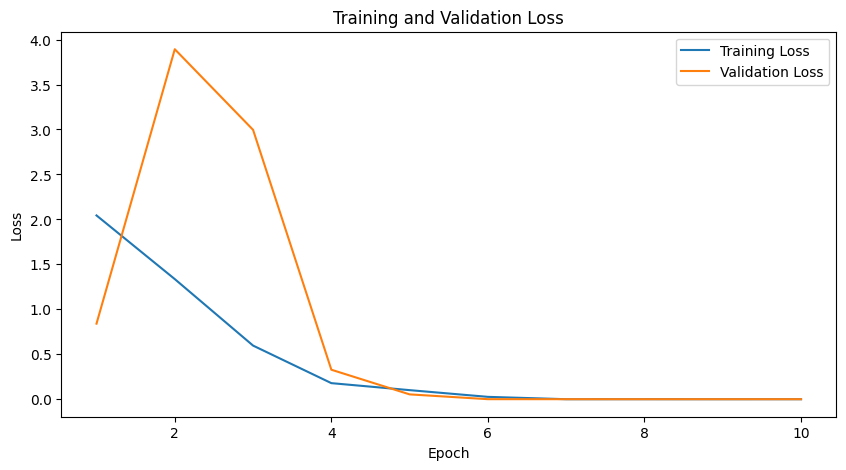

Training Model 2
Epoch [1/10], Training Loss: 2.2187
Validation Loss: 1.1402, Accuracy: 0.6281, Precision: 0.5735, Recall: 1.0000, F1 Score: 0.7289
Epoch [2/10], Training Loss: 1.0326
Validation Loss: 3.6144, Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1 Score: 0.7273
Epoch [3/10], Training Loss: 0.4810
Validation Loss: 2.2419, Accuracy: 0.7063, Precision: 0.6299, Recall: 1.0000, F1 Score: 0.7729
Epoch [4/10], Training Loss: 0.1246
Validation Loss: 0.4066, Accuracy: 0.8938, Precision: 0.8247, Recall: 1.0000, F1 Score: 0.9040
Epoch [5/10], Training Loss: 0.1047
Validation Loss: 0.0889, Accuracy: 0.9656, Precision: 0.9357, Recall: 1.0000, F1 Score: 0.9668
Epoch [6/10], Training Loss: 0.0339
Validation Loss: 0.0004, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/10], Training Loss: 0.0000
Validation Loss: 0.0001, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/10], Training Loss: 0.0001
Validation Loss: 0.0001, Accur

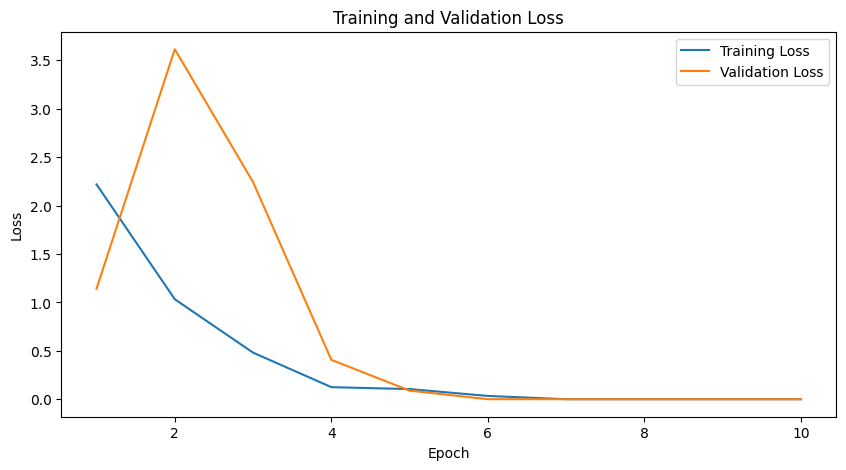

model.safetensors:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.00011189681750261027.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin
import torch.nn.functional as F

# Define the CNN model class
class CNNClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output

# Set hyperparameters
vocab_size = tokenizer.vocab_size
embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]
num_classes = 2
dropout = 0.2
num_epochs = 10
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = CNNClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "cnn-agent-suspect-only-scam-classifier-v1.0.pt")

    # Create a new instance of the best model
    best_model = CNNClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("cnn-agent-suspect-only-scam-classifier-v1.0")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

### Evaluation

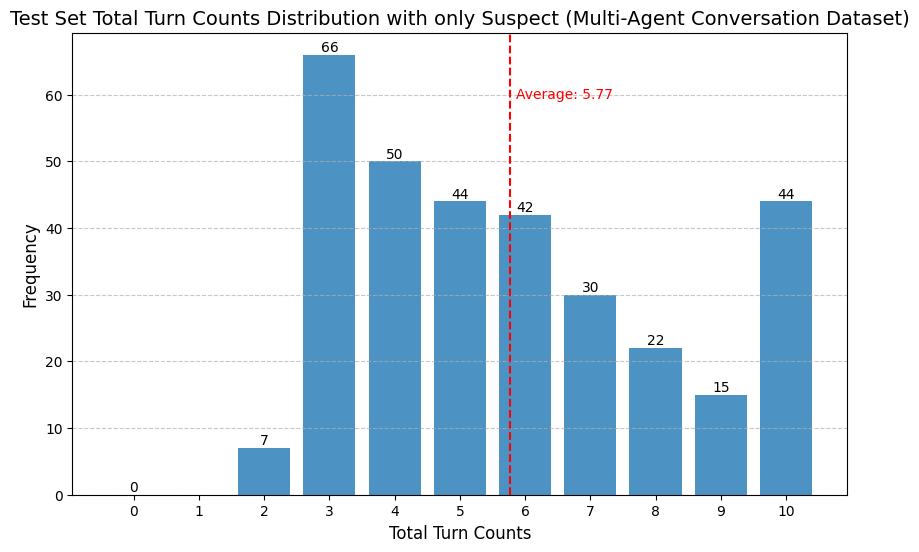

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_dataset = dataset["train"]
test_dataset = dataset["test"]
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Function to filter only the suspect's dialogue and remove the 'suspect:' string
def filter_suspect_dialogue(dialogue):
    parts = dialogue.split(' ')
    suspect_dialogue = []
    is_suspect = False
    for part in parts:
        if part.startswith('Suspect:'):
            is_suspect = True
        elif part.startswith('Innocent:'):
            is_suspect = False
        if is_suspect:
            suspect_dialogue.append(part)
    return ' '.join(suspect_dialogue).strip()

# Apply the function to the DataFrame
train_df['dialogue'] = train_df['dialogue'].apply(filter_suspect_dialogue)
test_df['dialogue'] = test_df['dialogue'].apply(filter_suspect_dialogue)

# Count the occurrences of "suspect:" and "innocent:" in each row
train_df['suspect_turns'] = train_df['dialogue'].str.count('Suspect:')
train_df['innocent_turns'] = train_df['dialogue'].str.count('Innocent:')
test_df['suspect_turns'] = test_df['dialogue'].str.count('Suspect:')
test_df['innocent_turns'] = test_df['dialogue'].str.count('Innocent:')

# Compute the total turns of "suspect:" and "innocent:" in each row
train_df['total_turns'] = train_df['suspect_turns'] + train_df['innocent_turns']
test_df['total_turns'] = test_df['suspect_turns'] + test_df['innocent_turns']

# Function to create the histogram plot
def plot_turn_counts_distribution(df, title, ax):
    # Calculate the frequency of each total turn count
    turn_counts_frequency = df['total_turns'].value_counts().sort_index()

    # Create a DataFrame with 'Total Turn Counts' and 'Frequency' columns
    mode_turns = pd.DataFrame({'Total Turn Counts': turn_counts_frequency.index, 'Frequency': turn_counts_frequency.values})

    # Add a bar for 0 count if it doesn't exist in the data
    if 0 not in mode_turns['Total Turn Counts'].values:
        mode_turns = pd.concat([pd.DataFrame({'Total Turn Counts': [0], 'Frequency': [0]}), mode_turns], ignore_index=True)

    ax.bar(mode_turns['Total Turn Counts'], mode_turns['Frequency'], align='center', alpha=0.8)
    ax.set_xlabel('Total Turn Counts', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(np.arange(0, mode_turns['Total Turn Counts'].max() + 1))
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add labels to the top of each bar
    for i, v in enumerate(mode_turns['Frequency']):
        ax.text(mode_turns['Total Turn Counts'][i], v + 0.5, str(v), fontsize=10, ha='center')

    # Calculate the average turn count
    average_turns = df['total_turns'].mean()

    # Add average information to the plot
    ax.axvline(average_turns, color='red', linestyle='--', label=f'Average: {average_turns:.2f}')
    ax.text(average_turns + 0.1, max(turn_counts_frequency) * 0.9, f'Average: {average_turns:.2f}', color='red')

# Create a single subplot for the test set
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distribution for the test set
plot_turn_counts_distribution(test_df, 'Test Set Total Turn Counts Distribution with only Suspect (Multi-Agent Conversation Dataset)', ax)

plt.show()

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

def truncate_dialogue(dialogue, max_turn):
    turns = dialogue.split()
    turn_count = 0
    truncated_dialogue = ""

    for turn in turns:
        if turn.startswith('Suspect:') or turn.startswith('Innocent:'):
            turn_count += 1

            if turn_count > max_turn:
                break

        truncated_dialogue += turn + ' '

    return truncated_dialogue.strip()

# Define the function to count occurrences and total turns
def count_turns(df):
    df['suspect_turns'] = df['dialogue'].str.count('Suspect:')
    df['innocent_turns'] = df['dialogue'].str.count('Innocent:')
    df['total_turns'] = df['suspect_turns'] + df['innocent_turns']
    return df

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dialogue column
def tokenize(batch):
    return tokenizer(batch["dialogue"], padding=True, truncation=True)

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # The collator rename the column label to labels

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
test_df_1turn = test_df.copy()
test_df_1turn['dialogue'] = test_df_1turn['dialogue'].apply(lambda x: truncate_dialogue(x, 1))
test_df_1turn = count_turns(test_df_1turn)

test_df_2turn = test_df.copy()
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(lambda x: truncate_dialogue(x, 2))
test_df_2turn = count_turns(test_df_2turn)

test_df_3turn = test_df.copy()
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(lambda x: truncate_dialogue(x, 3))
test_df_3turn = count_turns(test_df_3turn)

test_df_4turn = test_df.copy()
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(lambda x: truncate_dialogue(x, 4))
test_df_4turn = count_turns(test_df_4turn)

test_df_5turn = test_df.copy()
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(lambda x: truncate_dialogue(x, 5))
test_df_5turn = count_turns(test_df_5turn)

test_df_6turn = test_df.copy()
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(lambda x: truncate_dialogue(x, 6))
test_df_6turn = count_turns(test_df_6turn)

test_df_7turn = test_df.copy()
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(lambda x: truncate_dialogue(x, 7))
test_df_7turn = count_turns(test_df_7turn)

In [ ]:
# Function to filter only the suspect's dialogue and remove the 'suspect:' string
def filter_suspect_identifier(dialogue):
    suspect_dialogue = []
    lines = dialogue.splitlines()

    for line in lines:
        if line.startswith('Suspect:'):
            suspect_dialogue.append(line.replace('Suspect:', '').strip())

    return ' '.join(suspect_dialogue)

test_df_1turn['dialogue'] = test_df_1turn['dialogue'].apply(filter_suspect_identifier)
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(filter_suspect_identifier)
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(filter_suspect_identifier)
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(filter_suspect_identifier)
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(filter_suspect_identifier)
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(filter_suspect_identifier)
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(filter_suspect_identifier)

In [ ]:
test_df_2turn.head(2)

,dialogue,personality,labels,suspect_turns,innocent_turns,total_turns
0,"Hi, this is Karen from Smith's Auto Repair. I'm calling to confirm your appointment for a oil change and tire rotation on your vehicle, scheduled for tomorrow at 2 PM. Are you still available to bring it in at that time, Mr. Johnson? I just need to confirm the appointment, Mr. Johnson. We've had some cancellations in the past and I want to make sure we're prepared for your visit. Is there anything else you'd like to have done to your vehicle while it's in our shop?",aggressive,0,2,0,2
1,"Hi, is this Rachel? My name is Karen and I'm calling from Smithson's Dental Care. I'm calling to confirm your appointment with Dr. Lee on Thursday at 2 PM. Can you confirm that you're still able to make it? Sorry about that, Rachel. Just making sure you're still on for Thursday. We've had some last-minute cancellations lately and I want to make sure everyone's on the same page. You're all set, then. We'll see you at 2 PM on Thursday.",aggressive,0,2,0,2


In [ ]:
test_df_1turn = Dataset.from_pandas(test_df_1turn)
test_df_1turn = test_df_1turn.map(tokenize, batched=True)

test_df_2turn = Dataset.from_pandas(test_df_2turn)
test_df_2turn = test_df_2turn.map(tokenize, batched=True)

test_df_3turn = Dataset.from_pandas(test_df_3turn)
test_df_3turn = test_df_3turn.map(tokenize, batched=True)

test_df_4turn = Dataset.from_pandas(test_df_4turn)
test_df_4turn = test_df_4turn.map(tokenize, batched=True)

test_df_5turn = Dataset.from_pandas(test_df_5turn)
test_df_5turn = test_df_5turn.map(tokenize, batched=True)

test_df_6turn = Dataset.from_pandas(test_df_6turn)
test_df_6turn = test_df_6turn.map(tokenize, batched=True)

test_df_7turn = Dataset.from_pandas(test_df_7turn)
test_df_7turn = test_df_7turn.map(tokenize, batched=True)

test_dfs = [
    test_df_1turn,
    test_df_2turn,
    test_df_3turn,
    test_df_4turn,
    test_df_5turn,
    test_df_6turn,
    test_df_7turn,
]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_metric
import numpy as np

def evaluate_model(model, dataset, device):
    # Define the metric you want to use for evaluation
    metric = load_metric("accuracy", trust_remote_code=True)

    # Define a function to generate predictions
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Use the map() function to generate predictions
    def generate_predictions(examples):
        input_ids = torch.tensor(examples['input_ids']).to(device)
        attention_mask = torch.tensor(examples['attention_mask']).to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
        return {'predictions': logits}

    dataset = dataset.map(generate_predictions, batched=True, batch_size=32)

    # Compute the accuracy
    accuracy = compute_metrics((dataset['predictions'], dataset['labels']))
    print(f"Accuracy: {accuracy['accuracy']:.4f}")

    return accuracy

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

<ipython-input-12-ddd064c5d1ed>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9688


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9938


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9625


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9500


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9594


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9500


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Accuracy: 0.9500


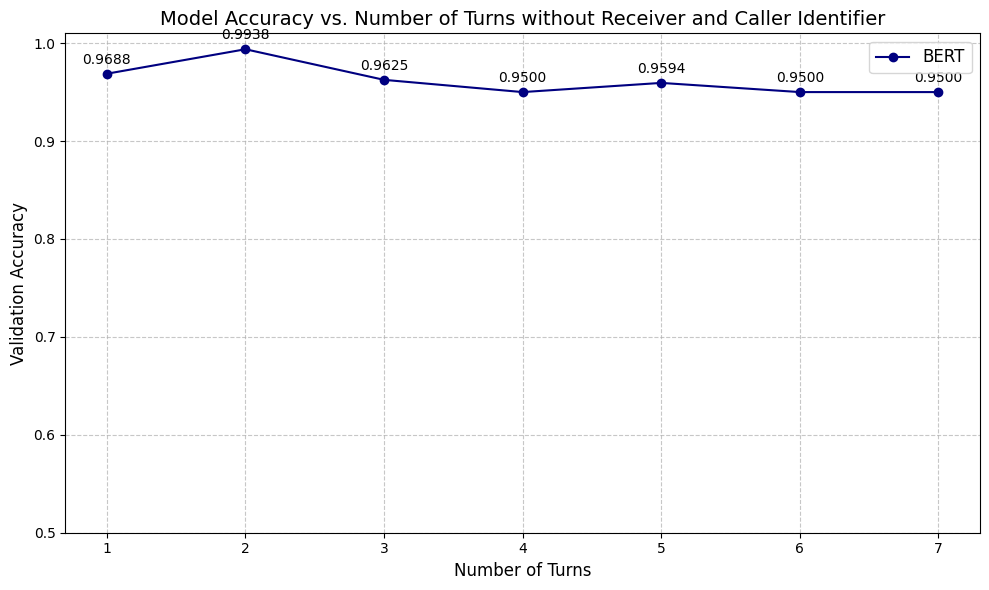

In [ ]:
from transformers import BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained("BothBosu/bert-agent-suspect-only-scam-classifier-v1.0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies
BERT_accuracies = []

for df in test_dfs:
    accuracy = evaluate_model(model, df, device)
    BERT_accuracies.append(accuracy['accuracy'])

# Plot the model accuracy graph
turns = range(1, 1 + len(BERT_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BERT_accuracies, marker='o', linestyle='-', color='navy', label='BERT')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BERT_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import DataLoader

test_df_1turn = test_df.copy()
test_df_1turn['dialogue'] = test_df_1turn['dialogue'].apply(lambda x: truncate_dialogue(x, 1))
test_df_1turn = count_turns(test_df_1turn)

test_df_2turn = test_df.copy()
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(lambda x: truncate_dialogue(x, 2))
test_df_2turn = count_turns(test_df_2turn)

test_df_3turn = test_df.copy()
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(lambda x: truncate_dialogue(x, 3))
test_df_3turn = count_turns(test_df_3turn)

test_df_4turn = test_df.copy()
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(lambda x: truncate_dialogue(x, 4))
test_df_4turn = count_turns(test_df_4turn)

test_df_5turn = test_df.copy()
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(lambda x: truncate_dialogue(x, 5))
test_df_5turn = count_turns(test_df_5turn)

test_df_6turn = test_df.copy()
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(lambda x: truncate_dialogue(x, 6))
test_df_6turn = count_turns(test_df_6turn)

test_df_7turn = test_df.copy()
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(lambda x: truncate_dialogue(x, 7))
test_df_7turn = count_turns(test_df_7turn)

test_df_1turn['dialogue'] = test_df_1turn['dialogue'].apply(filter_suspect_identifier)
test_df_2turn['dialogue'] = test_df_2turn['dialogue'].apply(filter_suspect_identifier)
test_df_3turn['dialogue'] = test_df_3turn['dialogue'].apply(filter_suspect_identifier)
test_df_4turn['dialogue'] = test_df_4turn['dialogue'].apply(filter_suspect_identifier)
test_df_5turn['dialogue'] = test_df_5turn['dialogue'].apply(filter_suspect_identifier)
test_df_6turn['dialogue'] = test_df_6turn['dialogue'].apply(filter_suspect_identifier)
test_df_7turn['dialogue'] = test_df_7turn['dialogue'].apply(filter_suspect_identifier)

test_df_1turn = Dataset.from_pandas(test_df_1turn)
test_df_1turn = test_df_1turn.map(tokenize, batched=True)
test_df_1turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_1turn = DataLoader(test_df_1turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_2turn = Dataset.from_pandas(test_df_2turn)
test_df_2turn = test_df_2turn.map(tokenize, batched=True)
test_df_2turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_2turn = DataLoader(test_df_2turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_3turn = Dataset.from_pandas(test_df_3turn)
test_df_3turn = test_df_3turn.map(tokenize, batched=True)
test_df_3turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_3turn = DataLoader(test_df_3turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_4turn = Dataset.from_pandas(test_df_4turn)
test_df_4turn = test_df_4turn.map(tokenize, batched=True)
test_df_4turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_4turn = DataLoader(test_df_4turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_5turn = Dataset.from_pandas(test_df_5turn)
test_df_5turn = test_df_5turn.map(tokenize, batched=True)
test_df_5turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_5turn = DataLoader(test_df_5turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_6turn = Dataset.from_pandas(test_df_6turn)
test_df_6turn = test_df_6turn.map(tokenize, batched=True)
test_df_6turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_6turn = DataLoader(test_df_6turn, batch_size=16, shuffle=False, collate_fn=data_collator)

test_df_7turn = Dataset.from_pandas(test_df_7turn)
test_df_7turn = test_df_7turn.map(tokenize, batched=True)
test_df_7turn.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_loader_7turn = DataLoader(test_df_7turn, batch_size=16, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
def evaluate_model(model, val_loader, device):
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Evaluate the model on different val_loaders
val_loaders = [
    val_loader_1turn,
    val_loader_2turn,
    val_loader_3turn,
    val_loader_4turn,
    val_loader_5turn,
    val_loader_6turn,
    val_loader_7turn,
]

config.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.8625
Validation Accuracy (3 turns): 0.8406
Validation Accuracy (4 turns): 0.8250
Validation Accuracy (5 turns): 0.8406
Validation Accuracy (6 turns): 0.7719
Validation Accuracy (7 turns): 0.7469
Validation Accuracy (8 turns): 0.7406


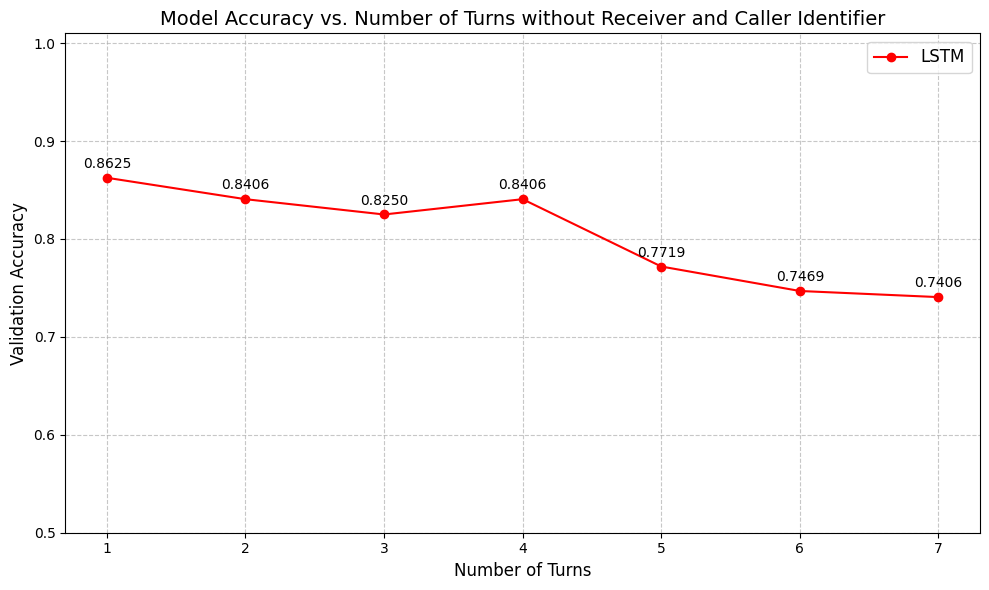

In [ ]:
from huggingface_hub import PyTorchModelHubMixin
import torch
import torch.nn as nn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the LSTM model class
class LSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, model_type="lstm"):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = LSTMClassifier.from_pretrained("BothBosu/lstm-agent-suspect-only-scam-classifier-v1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the LSTM model
LSTM_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    LSTM_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(1, 1 + len(LSTM_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, LSTM_accuracies, marker='o', linestyle='-', color='red', label='LSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(LSTM_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.5031
Validation Accuracy (3 turns): 0.5031
Validation Accuracy (4 turns): 0.5031
Validation Accuracy (5 turns): 0.5094
Validation Accuracy (6 turns): 0.6031
Validation Accuracy (7 turns): 0.6469
Validation Accuracy (8 turns): 0.6750


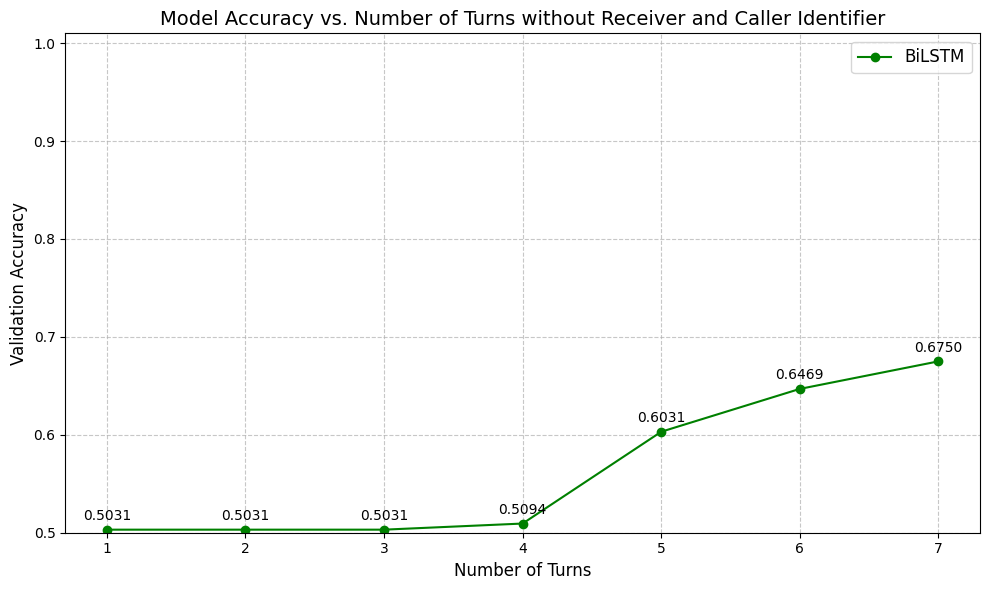

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the LSTM model class
class BiLSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiLSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = BiLSTMClassifier.from_pretrained("BothBosu/bilstm-agent-suspect-only-scam-classifier-v1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the BiLSTM model
BiLSTM_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    BiLSTM_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(1, 1 + len(BiLSTM_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BiLSTM_accuracies, marker='o', linestyle='-', color='green', label='BiLSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BiLSTM_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.5031
Validation Accuracy (3 turns): 0.5031
Validation Accuracy (4 turns): 0.5031
Validation Accuracy (5 turns): 0.5094
Validation Accuracy (6 turns): 0.6062
Validation Accuracy (7 turns): 0.6469
Validation Accuracy (8 turns): 0.6719


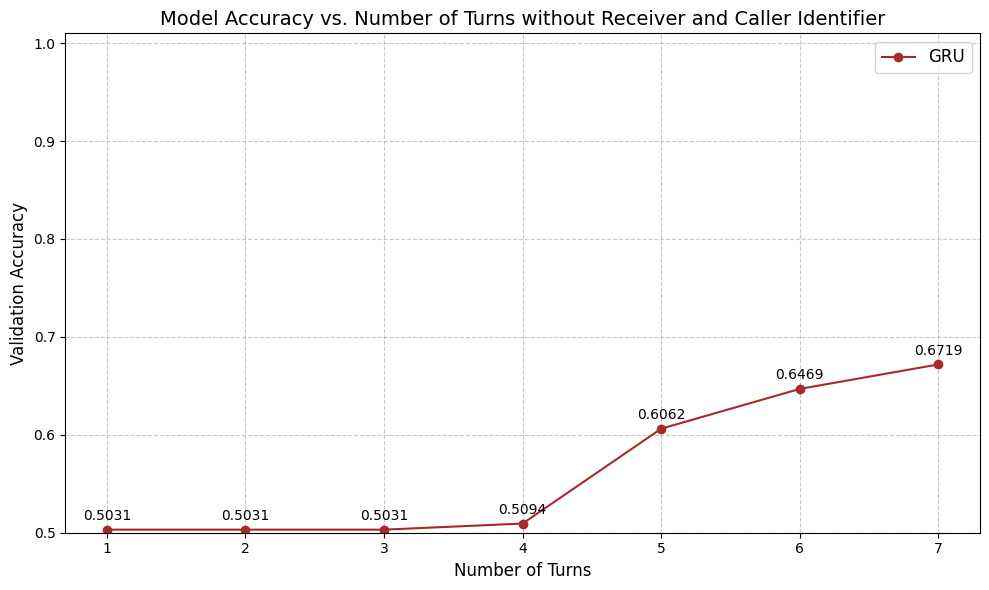

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the GRU model class
class GRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = GRUClassifier.from_pretrained("BothBosu/gru-agent-suspect-only-scam-classifier-v1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the GRU model
GRU_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    GRU_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(1, 1 + len(GRU_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, GRU_accuracies, marker='o', linestyle='-', color='brown', label='GRU')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(GRU_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 1.0000
Validation Accuracy (3 turns): 1.0000
Validation Accuracy (4 turns): 1.0000
Validation Accuracy (5 turns): 1.0000
Validation Accuracy (6 turns): 1.0000
Validation Accuracy (7 turns): 1.0000
Validation Accuracy (8 turns): 1.0000


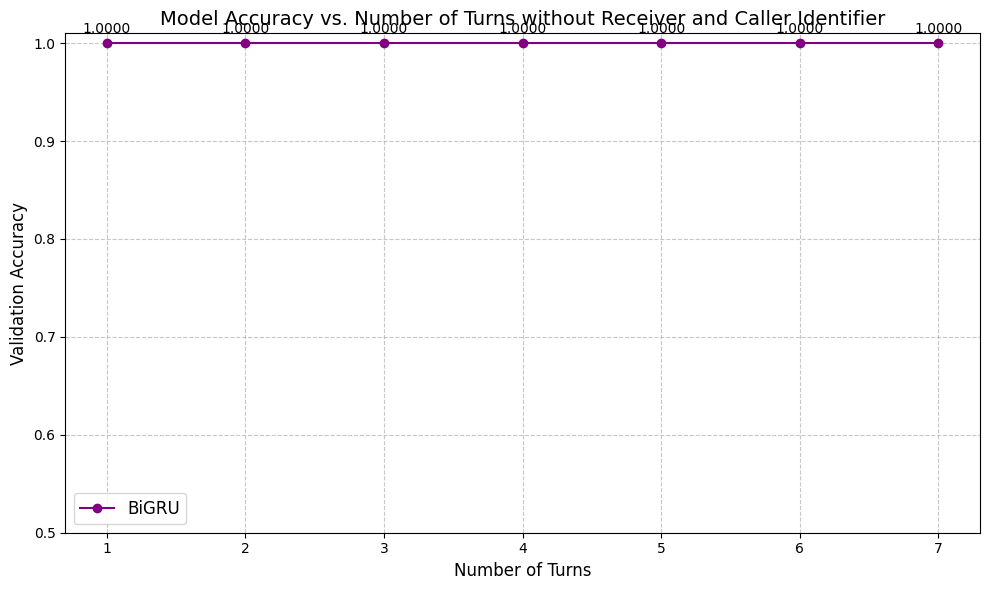

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the BiGRU model class
class BiGRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiGRU
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

model = BiGRUClassifier.from_pretrained("BothBosu/bigru-agent-suspect-only-scam-classifier-v1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import matplotlib.pyplot as plt

# Create a list to store the accuracies for the BiGRU model
BiGRU_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    BiGRU_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(1, 1 + len(BiGRU_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, BiGRU_accuracies, marker='o', linestyle='-', color='purple', label='BiGRU')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(BiGRU_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Validation Accuracy (2 turns): 0.9437
Validation Accuracy (3 turns): 1.0000
Validation Accuracy (4 turns): 1.0000
Validation Accuracy (5 turns): 1.0000
Validation Accuracy (6 turns): 1.0000
Validation Accuracy (7 turns): 1.0000
Validation Accuracy (8 turns): 1.0000


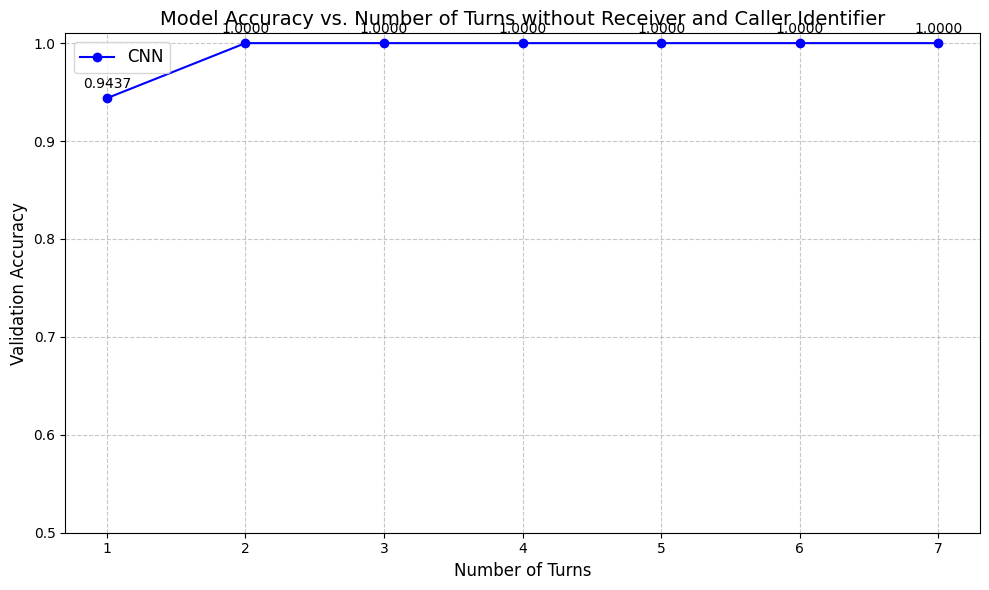

In [ ]:
from huggingface_hub import PyTorchModelHubMixin
import torch.nn.functional as F

# Define the CNN model class
class CNNClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output


model = CNNClassifier.from_pretrained("BothBosu/cnn-agent-suspect-only-scam-classifier-v1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create a list to store the accuracies
CNN_accuracies = []

for i, val_loader in enumerate(val_loaders, start=2):
    accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy ({i} turns): {accuracy:.4f}")
    CNN_accuracies.append(accuracy)

# Plot the model accuracy graph
turns = range(1, 1 + len(CNN_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(turns, CNN_accuracies, marker='o', linestyle='-', color='blue', label='CNN')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Accuracy vs. Number of Turns without Receiver and Caller Identifier', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(CNN_accuracies):
    plt.text(turns[i], acc + 0.01, f'{acc:.4f}', fontsize=10, ha='center')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

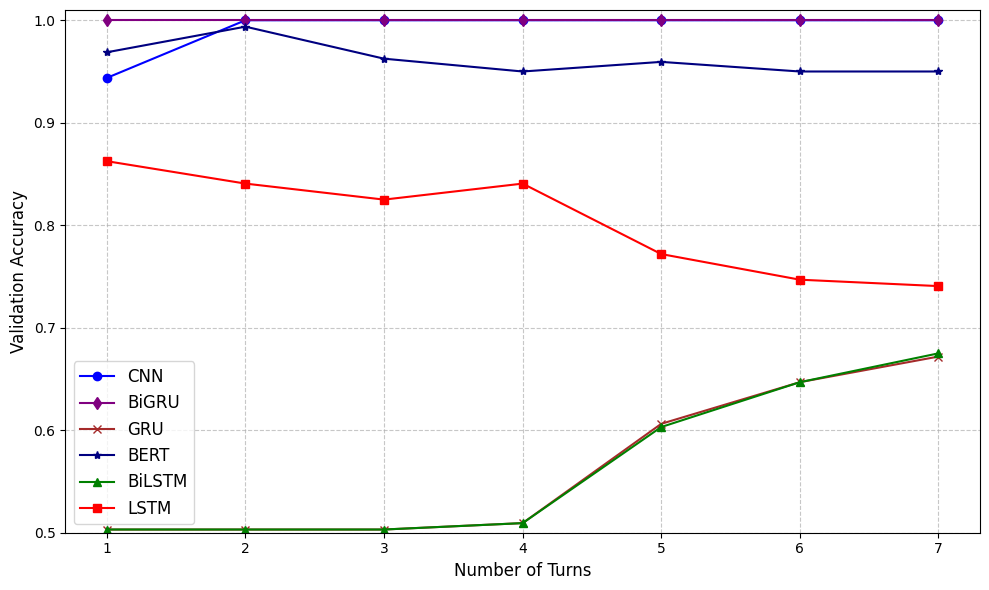

In [ ]:
import matplotlib.pyplot as plt

# Plot the model accuracy graph
turns = range(1, 1 + len(CNN_accuracies))

plt.figure(figsize=(10, 6))

plt.plot(turns, CNN_accuracies, marker='o', linestyle='-', color='blue', label='CNN')
plt.plot(turns, BiGRU_accuracies, marker='d', linestyle='-', color='purple', label='BiGRU')
plt.plot(turns, GRU_accuracies, marker='x', linestyle='-', color='brown', label='GRU')
plt.plot(turns, BERT_accuracies, marker='*', linestyle='-', color='navy', label='BERT')
plt.plot(turns, BiLSTM_accuracies, marker='^', linestyle='-', color='green', label='BiLSTM')
plt.plot(turns, LSTM_accuracies, marker='s', linestyle='-', color='red', label='LSTM')

plt.xlabel('Number of Turns', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
# plt.title('Model Accuracy vs. Number of Turns with only Suspect (Multi-Agent Conversation Datset)', fontsize=14)

plt.xticks(turns)
plt.ylim(0.5, 1.01)  # Set the y-axis limits starting from 0.5
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Conclusion
- Training data skewed toward shorter turn improve accuracy on shorter turn while not compromising the accuracy of longer tern